<a href="https://colab.research.google.com/github/HowonRyu/ConfidenceSet/blob/main/ConfidenceSet_Demonstration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialize

To add:
confidence set simulation -> make it into function

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.colors import Normalize
import random
import sys
import os
import math
import scipy.stats
import pickle

#!rm -rf ConfSets
#!git clone https://github.com/TomMaullin/ConfSets.git
#sys.path.append('/content/ConfSets/lib/')
#from generateData import *
#from boundary import *

#!pip install git+https://github.com/HowonRyu/ConfidenceSet.git
from confidenceset.random_field_generator import *
from confidenceset.confset import *
from confidenceset.plot import *
from confidenceset.test import *
from confidenceset.simulation import *

%load_ext autoreload
%autoreload 2

/var/folders/ly/8p16t5q955n0ptfrv1_8_r8m0000gn/T/ipykernel_68861/4132811794.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Defining specs for the shape

In [2]:
dim_100 = (80,100,100)
dim_50 = (80, 50, 50)


spec_50, spec_100 = gen_spec(fwhm_sig=10, fwhm_noise=0, std=5, mag=4, r=0.5)
spec_50_sig20, spec_100_sig20 = gen_spec(fwhm_sig=20, fwhm_noise=0, std=5, mag=4, r=0.5)
spec_50_noise10, spec_100_noise10 = gen_spec(fwhm_sig=10, fwhm_noise=10, std=5, mag=4, r=0.5)
spec_50_noise20, spec_100_noise20 = gen_spec(fwhm_sig=10, fwhm_noise=20, std=5, mag=4, r=0.5)

# for plot functions
shape_specs_50 = [spec_50, spec_50_sig20, spec_50_noise10, spec_50_noise20]
shape_specs_100 = [spec_100, spec_100_sig20, spec_100_noise10, spec_100_noise20]
shape_specs_sim = [shape_specs_50, shape_specs_100]

# for signal plotting
spec_cir_50, spec_elp_50, spec_ramp_50 = spec_50
spec_cir_100, spec_elp_100, spec_ramp_100 = spec_100

spec_cir_50_smth, spec_elp_50_smth, spec_ramp_50_smth = spec_50_noise10
spec_cir_100_smth, spec_elp_100_smth, spec_ramp_100_smth = spec_100_noise10

# FDR Confidence Set



\begin{array}{|c|c|} \hline
 & N & P &  \\ \hline
H_0 & TN & FP & m_0 \\
H_1 & FN & TP & m-m_0 \\ \hline
 & m-R & R & m \\ \hline
\end{array}


**Family Wise Error Rate (FWER)**
*   $FWER = P(FP \ge 1 | H_0)$
*   In multiple testing, use Bonferroni to control for: $FWER <\frac{\alpha}{m}$



**False Discovery Rate (FDR)**

*   $FDR = E(\frac{FP}{R} | R>0)P(R>0) = E \frac{FP}{\max(1,R)} $
*  ((If you can add BH proof))

## Signals and Confidence Sets

Different settings of image size and variance

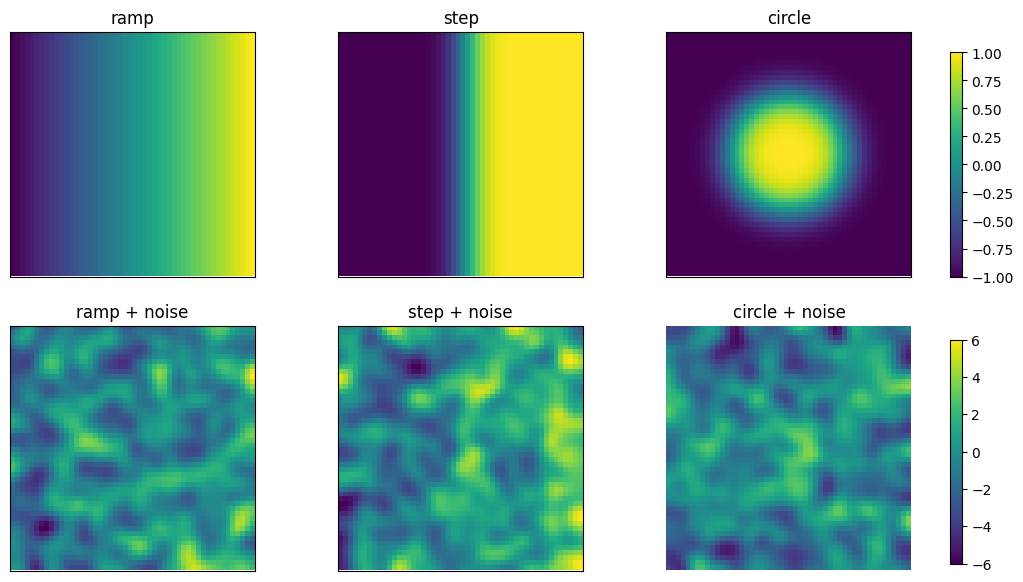

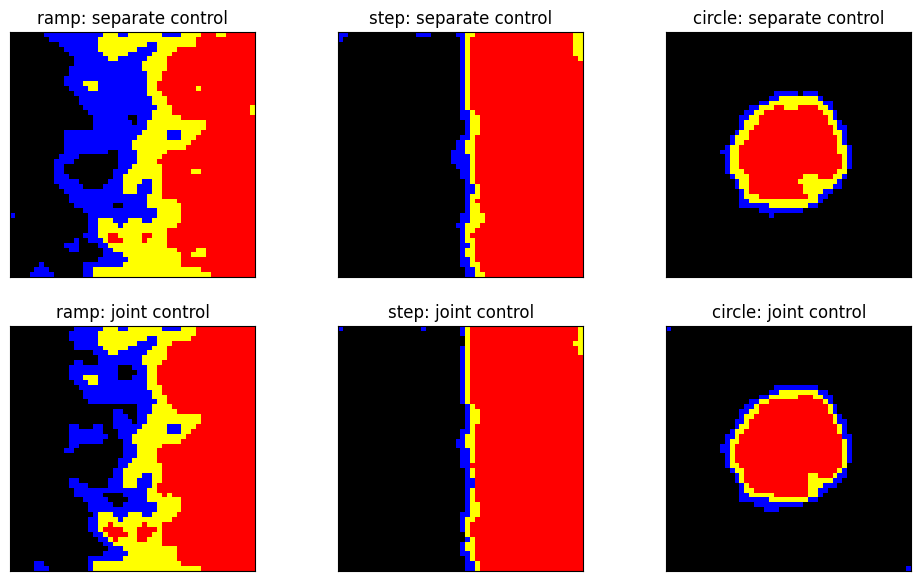

In [4]:
# signal + noise plots
signal_smth = 8
noise_smth = 4
std = 1.5

ramp_spec = {'direction': 1,
                  'mag':(-1,1),
                  'fwhm_noise': noise_smth,
               'std': std}

step_spec = {'fwhm_noise': noise_smth,
             'fwhm_signal' : signal_smth,
             'std': std}

circle_spec = {'r':0.5, 'mag':2, 'background_mag':-1,
                  'fwhm_signal': signal_smth,
                  'fwhm_noise': noise_smth,
                  'std': std}

ramp, ramp_mu = gen_2D((80,50,50), shape="ramp", shape_spec = ramp_spec)
step, step_mu = gen_2D((80,50,50), shape="step", shape_spec = step_spec)
circle, circle_mu = gen_2D((80,50,50), shape="circle", shape_spec = circle_spec)

fontsize = 12
figsize = (12, 7)

fig, axs = plt.subplots(2, 3, figsize=figsize)
plt.axis('off')
im = axs[0,0].imshow(ramp_mu)
axs[0,0].set_title("ramp", fontsize = fontsize)
#fig.colorbar(im, ax=axs[0, 0])
im = axs[0,1].imshow(step_mu)
axs[0,1].set_title("step", fontsize = fontsize)
im = axs[0,2].imshow(circle_mu)
axs[0,2].set_title("circle", fontsize = fontsize)

cbar_ax1 = fig.add_axes([0.92, 0.53, 0.01, 0.32])  # [left, bottom, width, height]
cbar1 = fig.colorbar(im, cax=cbar_ax1)
im.set_clim(vmin=-1, vmax=1)


im = axs[1,0].imshow(ramp[0,:,:])
axs[1,0].set_title("ramp + noise", fontsize = fontsize)
im = axs[1,1].imshow(step[0,:,:])
axs[1,1].set_title("step + noise", fontsize = fontsize)
im = axs[1,2].imshow(circle[0,:,:])
axs[1,2].set_title("circle + noise", fontsize = fontsize)

cbar_ax2 = fig.add_axes([0.92, 0.12, 0.01, 0.32])  
cbar2 = fig.colorbar(im, cax=cbar_ax2)
im.set_clim(vmin=-6, vmax=6)
axs = axs.ravel()  # Convert axs to a 1D array
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()


# confset plot

ramp_lower, ramp_upper, ramp_Achat, _, _ = fdr_confset(data=ramp, threshold=0, method="separate_adaptive", alpha=0.05,
             k=2, alpha0=0.05 / 4, alpha1=0.05 / 2)

step_lower, step_upper, step_Achat, _, _ = fdr_confset(data=step, threshold=0, method="separate_adaptive", alpha=0.05,
             k=2, alpha0=0.05 / 4, alpha1=0.05 / 2)
circle_lower, circle_upper, circle_Achat, _, _ = fdr_confset(data=circle, threshold=0, method="separate_adaptive", alpha=0.05,
             k=2, alpha0=0.05 / 4, alpha1=0.05 / 2)

ramp_lower2, ramp_upper2, ramp_Achat2, _, _ = fdr_confset(data=ramp, threshold=0, method="joint", alpha=0.1,
             k=2, alpha0=0.1 / 4, alpha1=0.1 / 2)

step_lower2, step_upper2, step_Achat2, _, _ = fdr_confset(data=step, threshold=0, method="joint", alpha=0.1,
             k=2, alpha0=0.1 / 4, alpha1=0.1 / 2)
circle_lower2, circle_upper2, circle_Achat2, _, _ = fdr_confset(data=circle, threshold=0, method="joint", alpha=0.1,
             k=2, alpha0=0.1 / 4, alpha1=0.1 / 2)




fig, axs = plt.subplots(2, 3, figsize=figsize)
cmap1 = colors.ListedColormap(['black', 'blue'])
cmap2 = colors.ListedColormap(['none', 'yellow'])
cmap3 = colors.ListedColormap(['none', 'red'])

im = axs[0,0].imshow(ramp_lower, cmap=cmap1)
im = axs[0,0].imshow(ramp_Achat, cmap=cmap2)
im = axs[0,0].imshow(ramp_upper, cmap=cmap3)
axs[0,0].set_title("ramp: separate control", fontsize = fontsize)

im = axs[0,1].imshow(step_lower, cmap=cmap1)
im = axs[0,1].imshow(step_Achat, cmap=cmap2)
im = axs[0,1].imshow(step_upper, cmap=cmap3)
axs[0,1].set_title("step: separate control", fontsize = fontsize)

im = axs[0,2].imshow(circle_lower, cmap=cmap1)
im = axs[0,2].imshow(circle_Achat, cmap=cmap2)
im = axs[0,2].imshow(circle_upper, cmap=cmap3)
axs[0,2].set_title("circle: separate control", fontsize = fontsize)


im = axs[1,0].imshow(ramp_lower2, cmap=cmap1)
im = axs[1,0].imshow(ramp_Achat2, cmap=cmap2)
im = axs[1,0].imshow(ramp_upper2, cmap=cmap3)
axs[1,0].set_title("ramp: joint control", fontsize = fontsize)

im = axs[1,1].imshow(step_lower2, cmap=cmap1)
im = axs[1,1].imshow(step_Achat2, cmap=cmap2)
im = axs[1,1].imshow(step_upper2, cmap=cmap3)
axs[1,1].set_title("step: joint control", fontsize = fontsize)

im = axs[1,2].imshow(circle_lower2, cmap=cmap1)
im = axs[1,2].imshow(circle_Achat2, cmap=cmap2)
im = axs[1,2].imshow(circle_upper2, cmap=cmap3)
axs[1,2].set_title("circle: joint control", fontsize = fontsize)

axs = axs.ravel()  # Convert axs to a 1D array
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()






## Confidence Set Construction
See how one-sided and two-sided tests and sub-setting for inner and outer confidence sets are constructd

### Joint and Separate Error Control
 Used k=2, $\alpha_0 = 0.05/4$, $\alpha_1 = 0.05/2$

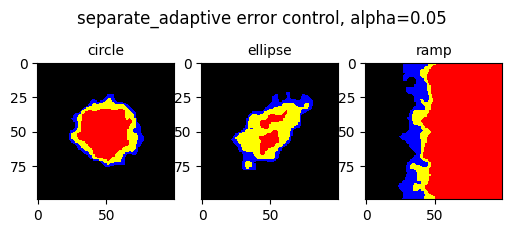

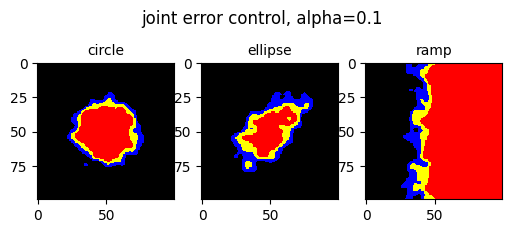

In [24]:
fn = 6
fs = 40
figsize = (6,2.5)
mag=5
std = 1.5
conf_plot_agg(threshold=2, method="separate_adaptive", seed=1004, std=std, mag=mag, fwhm_noise=fn, fwhm_signal=fs,  fontsize=10, alpha=0.05, figsize = figsize)
conf_plot_agg(threshold=2, method="joint", seed=1004, std=std, mag=mag, fwhm_noise=fn, fwhm_signal=fs,  fontsize=10, alpha=0.1, figsize = figsize)


# FDR Simulations

## simulation signals

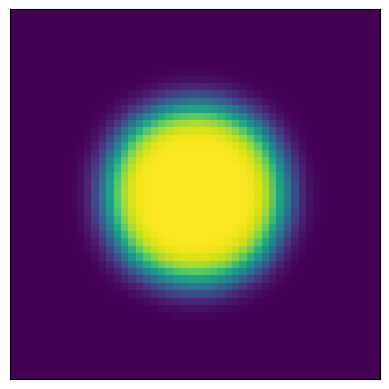

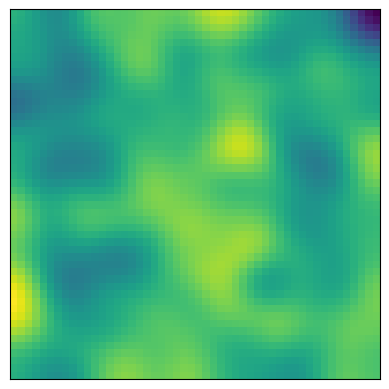

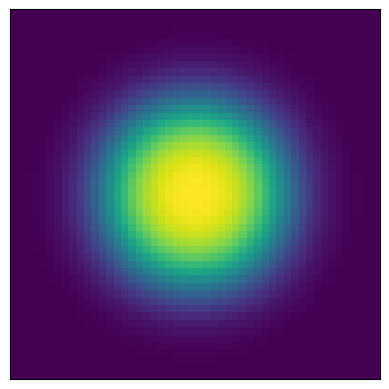

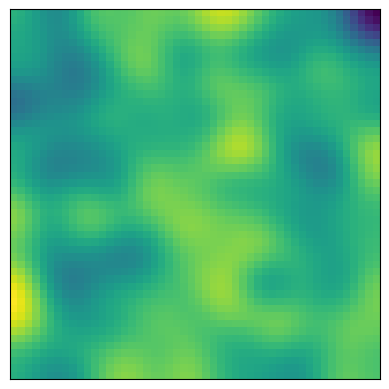

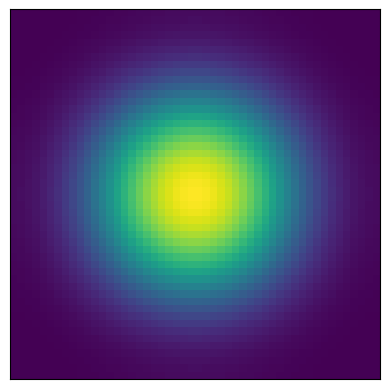

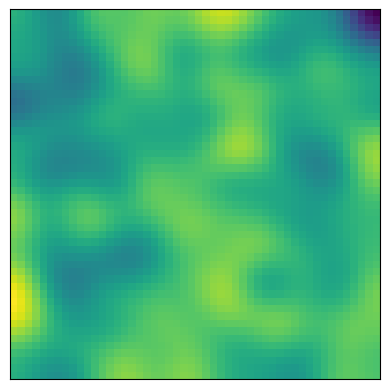

In [23]:
noise = 7
shape_spec_circle5 = {'r':0.5, 'mag':2,
                    'background_mag':-1,
                    'fwhm_signal': 5,
                    'fwhm_noise': noise,
                    'std': 1 }
shape_spec_circle10 = {'r':0.5, 'mag':2,
                    'background_mag':-1,
                    'fwhm_signal': 10,
                    'fwhm_noise': noise,
                    'std': 1 }
shape_spec_circle15 = {'r':0.5, 'mag':2,
                    'background_mag':-1,
                    'fwhm_signal': 15,
                    'fwhm_noise': noise,
                    'std': 1 }


signal = 5
data_sim5, mu_sim5 = gen_2D(dim=(1, 50, 50), shape="circle", shape_spec=shape_spec_circle5, seed=12352, truncate=3)
plt.imshow(mu_sim5)
plt.xticks([])
plt.yticks([])
plt.show()

plt.imshow(np.mean(data_sim5, axis=0))
plt.xticks([])
plt.yticks([])
plt.show()

signal = 10
data_sim10, mu_sim10 = gen_2D(dim=(1, 50, 50), shape="circle", shape_spec=shape_spec_circle10, seed=12352, truncate=3)
plt.imshow(mu_sim10)
plt.xticks([])
plt.yticks([])
plt.show()

plt.imshow(np.mean(data_sim10, axis=0))
plt.xticks([])
plt.yticks([])
plt.show()

signal = 15
data_sim15, mu_sim15 = gen_2D(dim=(1, 50, 50), shape="circle", shape_spec=shape_spec_circle15, seed=12352, truncate=3)
plt.imshow(mu_sim15)
plt.xticks([])
plt.yticks([])
plt.show()

plt.imshow(np.mean(data_sim15, axis=0))
plt.xticks([])
plt.yticks([])
plt.show()

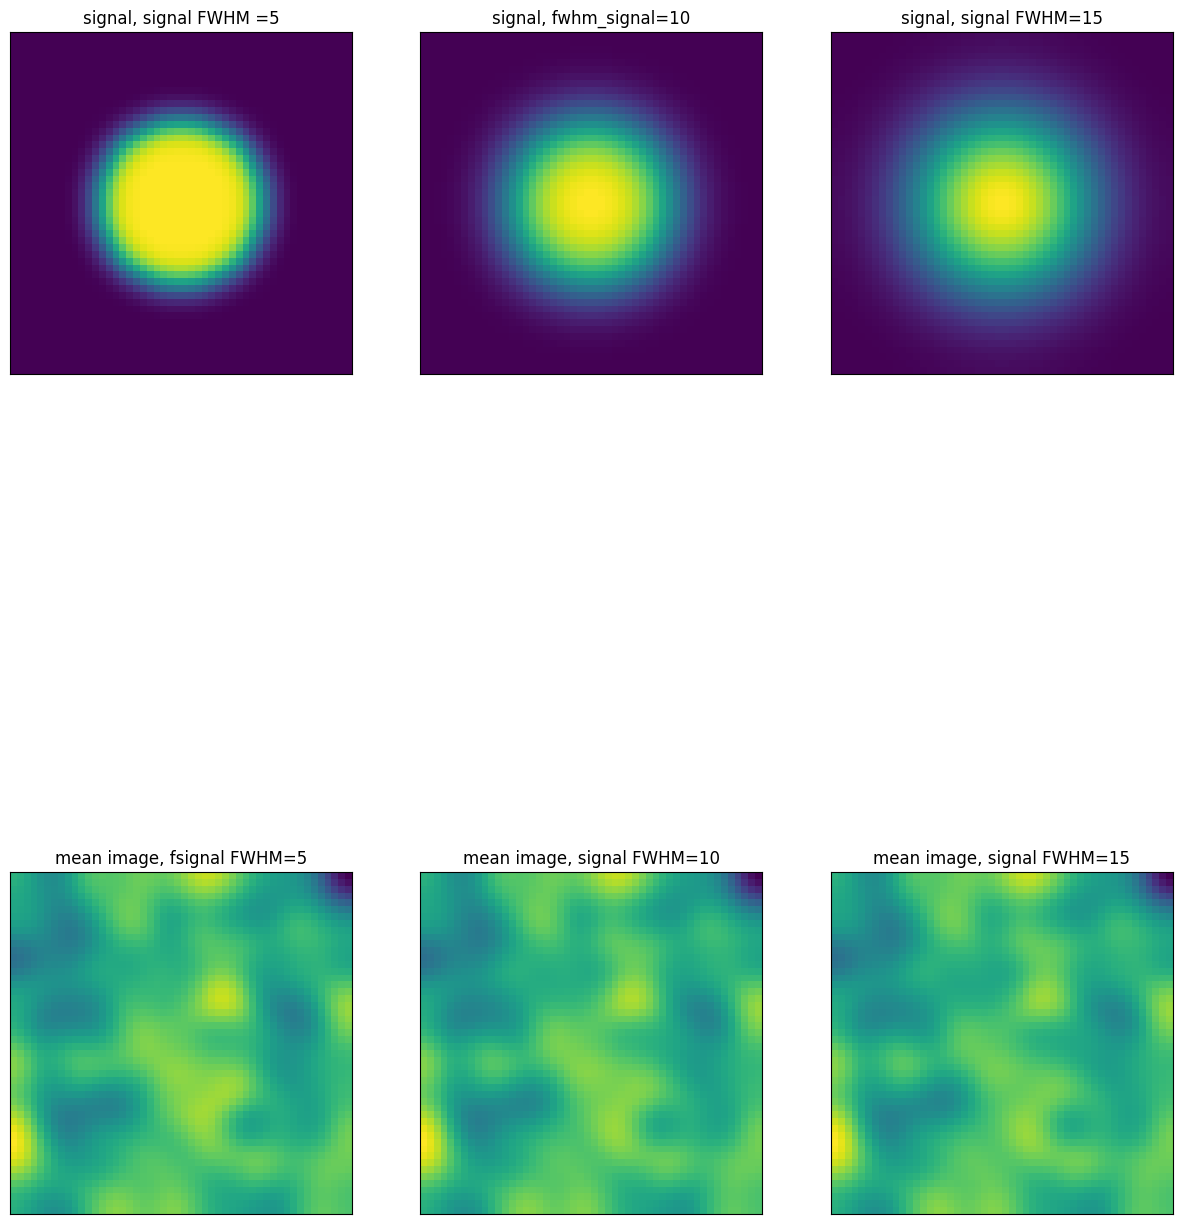

In [16]:
noise = 7
shape_spec_circle5 = {'r':0.5, 'mag':2,
                    'background_mag':-1,
                    'fwhm_signal': 5,
                    'fwhm_noise': noise,
                    'std': 1 }
shape_spec_circle10 = {'r':0.5, 'mag':2,
                    'background_mag':-1,
                    'fwhm_signal': 10,
                    'fwhm_noise': noise,
                    'std': 1 }
shape_spec_circle15 = {'r':0.5, 'mag':2,
                    'background_mag':-1,
                    'fwhm_signal': 15,
                    'fwhm_noise': noise,
                    'std': 1 }


signal = 5
data_sim5, mu_sim5 = gen_2D(dim=(1, 50, 50), shape="circle", shape_spec=shape_spec_circle5, seed=12352, truncate=3)
plt.imshow(mu_sim5)
plt.set_xticks([])
plt.set_yticks([])

plt.imshow(np.mean(data_sim5, axis=0))


fig, axs = plt.subplots(2,3, figsize=(15,20))


img = axs[1,0].imshow(np.mean(data_sim5, axis=0))
img = axs[1,0].set_title(f"mean image, fsignal FWHM={signal}")
img = axs[1,0].set_xticks([])
img = axs[1,0].set_yticks([])

signal = 10
data_sim10, mu_sim10 = gen_2D(dim=(1, 50, 50), shape="circle", shape_spec=shape_spec_circle10, seed=12352, truncate=3)
img = axs[0,1].imshow(mu_sim10)
img = axs[0,1].set_title(f"signal, fwhm_signal={signal}")
img = axs[1,1].imshow(np.mean(data_sim10, axis=0))
img = axs[1,1].set_title(f"mean image, signal FWHM={signal}")
img = axs[0,1].set_xticks([])
img = axs[0,1].set_yticks([])
img = axs[1,1].set_xticks([])
img = axs[1,1].set_yticks([])

signal = 15
data_sim15, mu_sim15 = gen_2D(dim=(1, 50, 50), shape="circle", shape_spec=shape_spec_circle15, seed=12352, truncate=3)
img = axs[0,2].imshow(mu_sim15)
img = axs[0,2].set_title(f"signal, signal FWHM={signal}")
img = axs[1,2].imshow(np.mean(data_sim15, axis=0))
img = axs[1,2].set_title(f"mean image, signal FWHM={signal}")
img = axs[0,2].set_xticks([])
img = axs[0,2].set_yticks([])
img = axs[1,2].set_xticks([])
img = axs[1,2].set_yticks([])


#cbar_ax1 = fig.add_axes([0.95, 0.25, 0.015, 0.5])  # [left, bottom, width, height]
#cbar1 = fig.colorbar(img, cax=cbar_ax1, cmap=plt.cm.get_cmap('viridis'))
#img.set_clim(vmin=-1, vmax=1) 


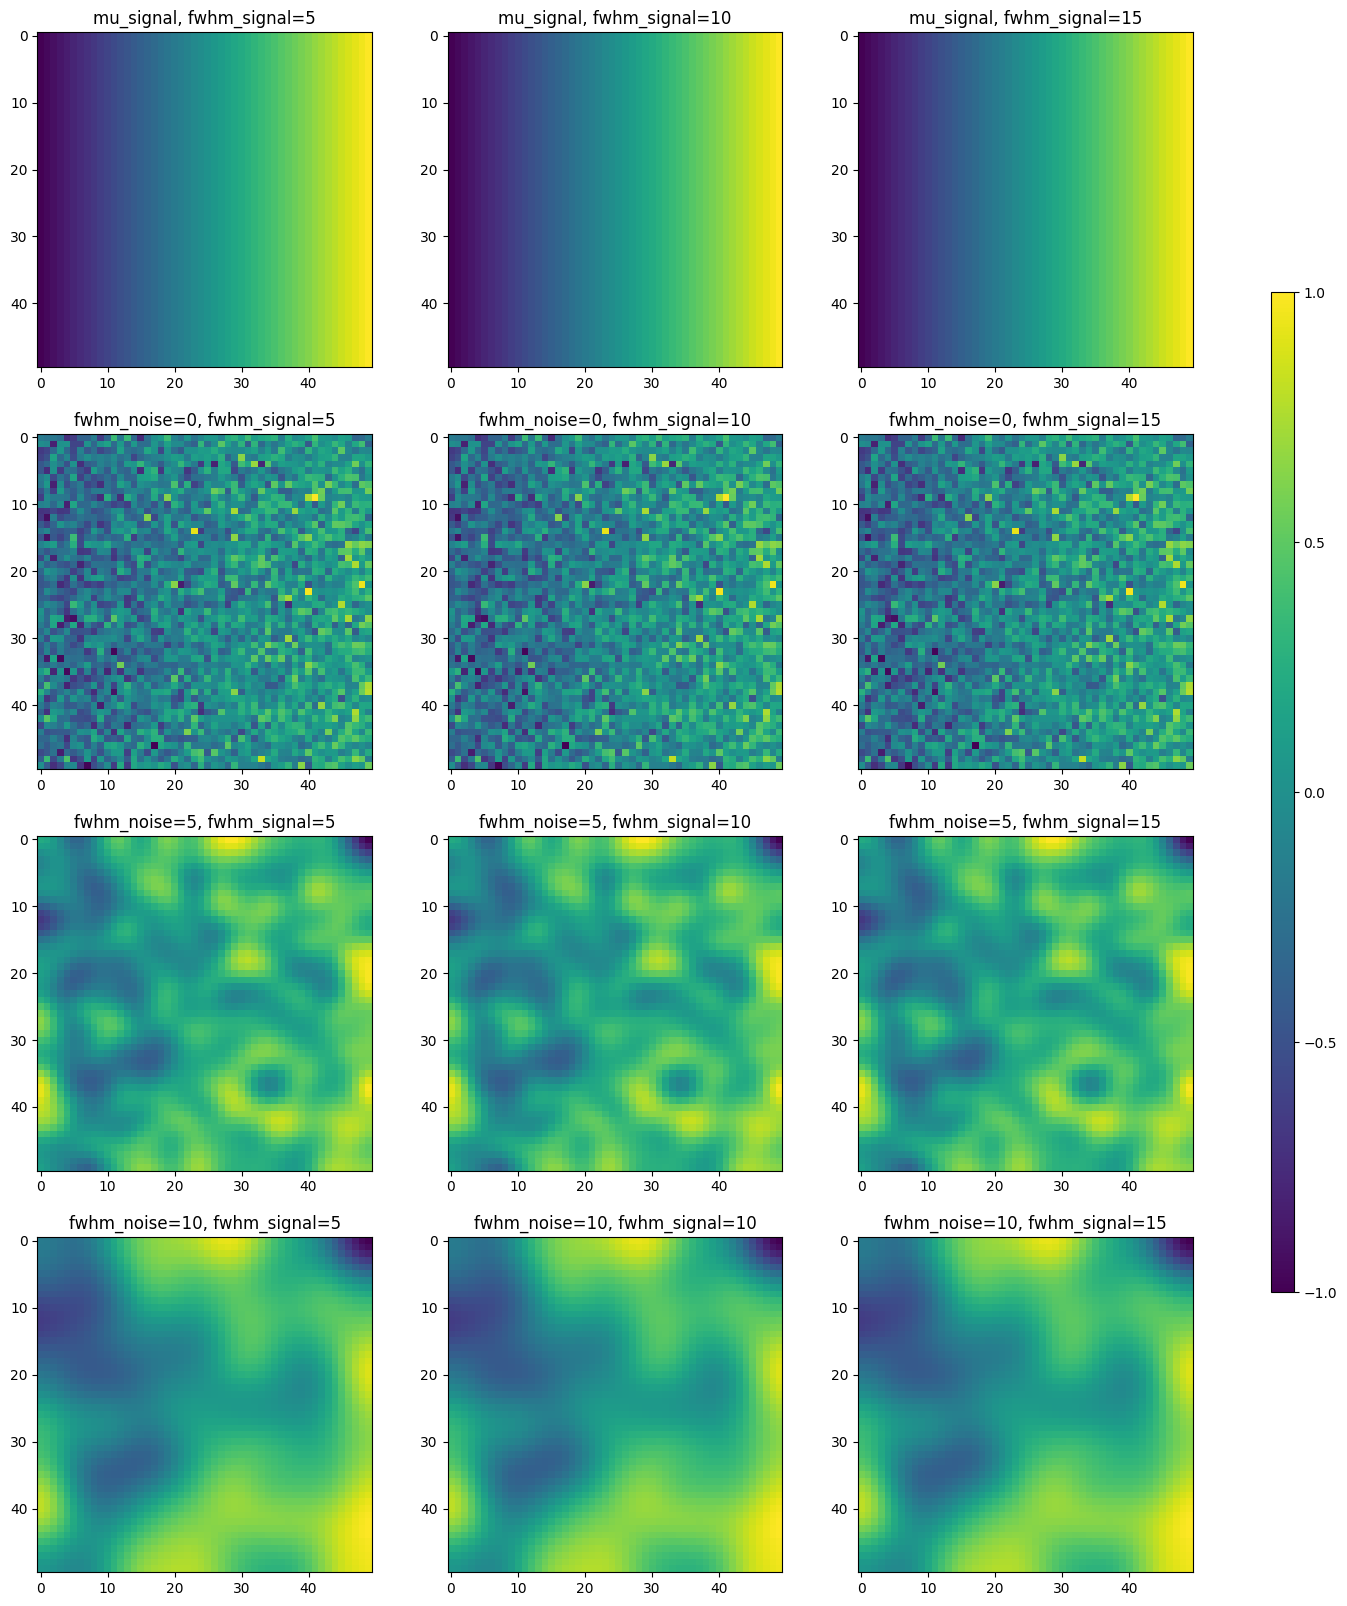

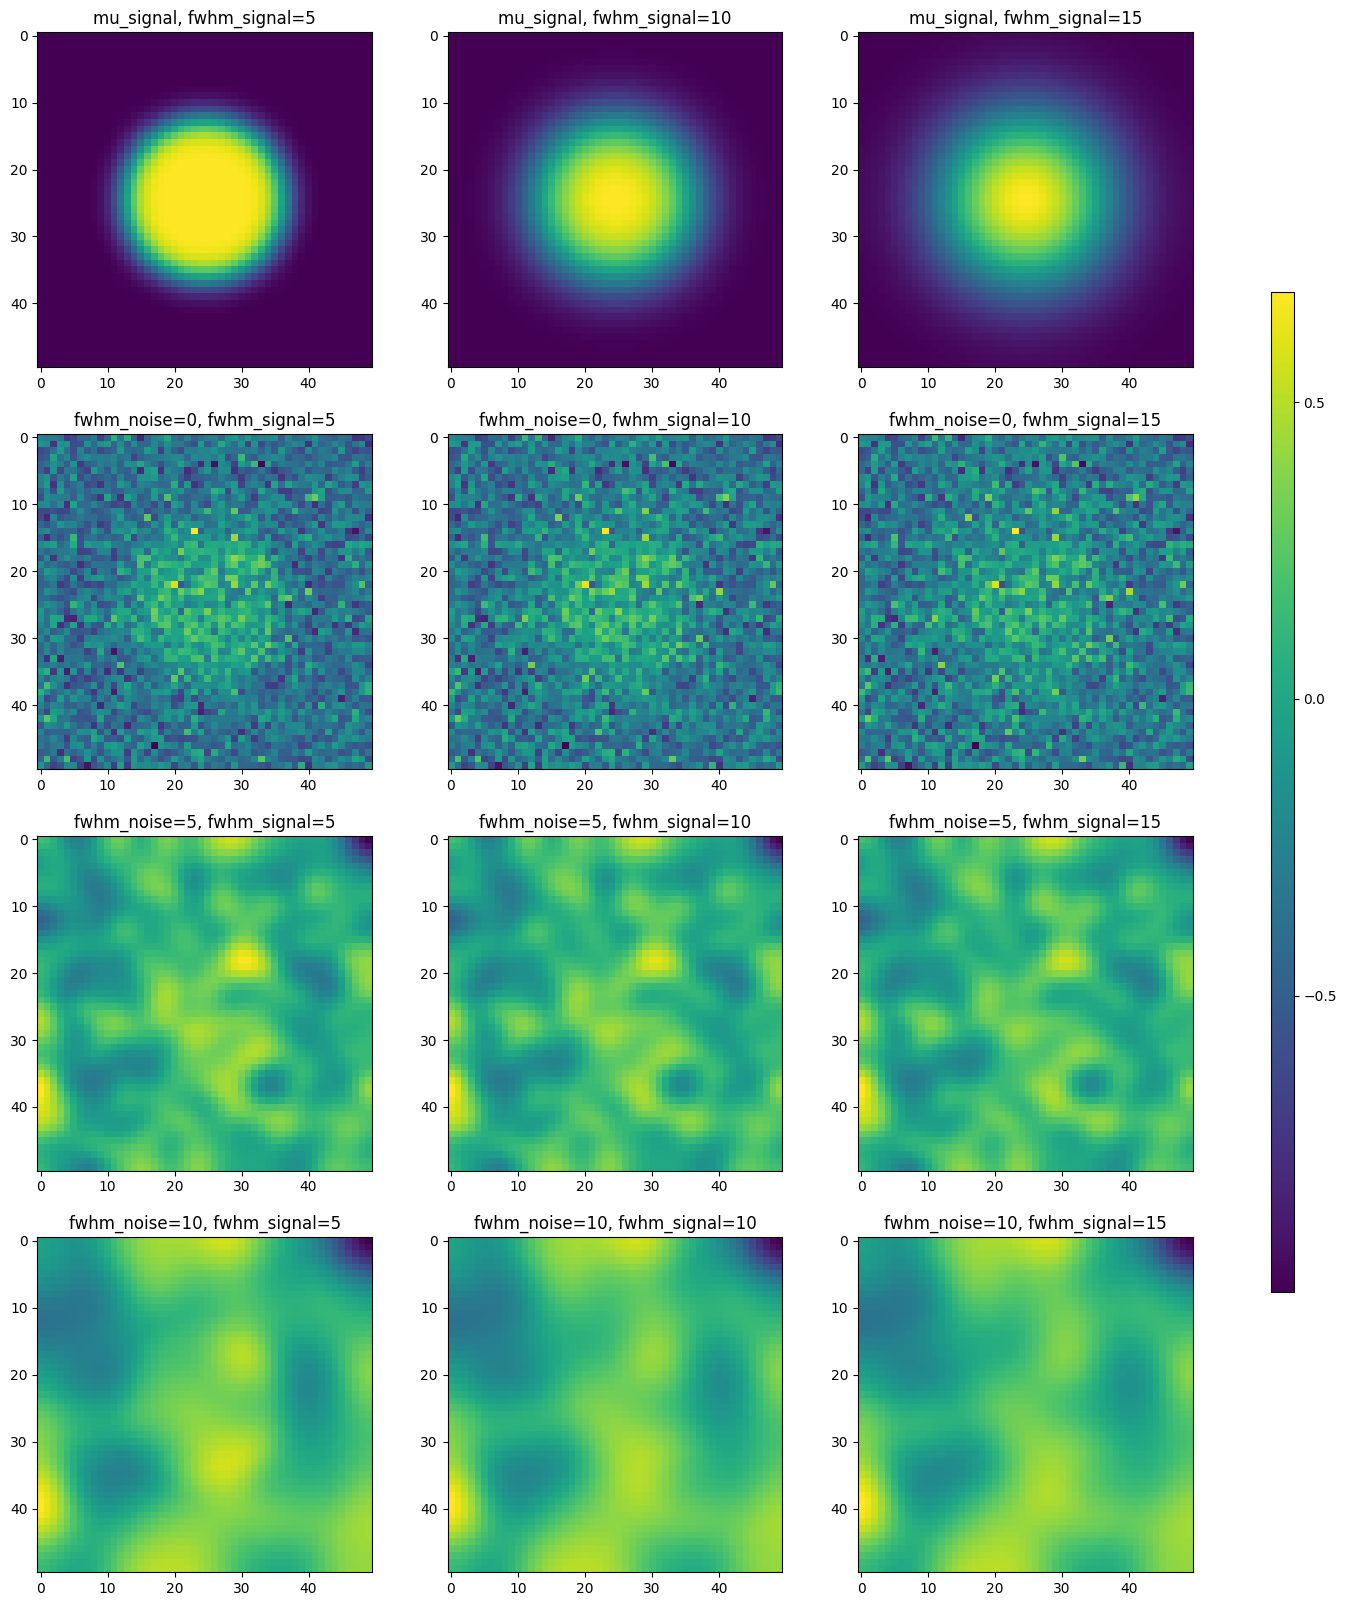

In [17]:
fwhm_signal_vec = [5, 10, 15]
fwhm_noise_vec = [0, 5, 10]

shape_spec_circle = {'r':0.5, 'mag':2,
                    'background_mag':-1,
                    'fwhm_signal': 0,
                    'fwhm_noise': 0,
                    'std': 1 }

shape_spec_step = {'fwhm_signal': 0,
                   'fwhm_noise': 0,
                   'std': 1}

shape_spec_ramp = {'direction': 1,
                  'mag':(-1,1),
                  'fwhm_noise': 0,
               'std': 1}

get_sim_signal(shape="ramp", shape_spec=shape_spec_ramp, fwhm_signal_vec=fwhm_signal_vec, fwhm_noise_vec=fwhm_noise_vec)
get_sim_signal(shape="circle", shape_spec=shape_spec_circle, fwhm_signal_vec=fwhm_signal_vec, fwhm_noise_vec=fwhm_noise_vec)

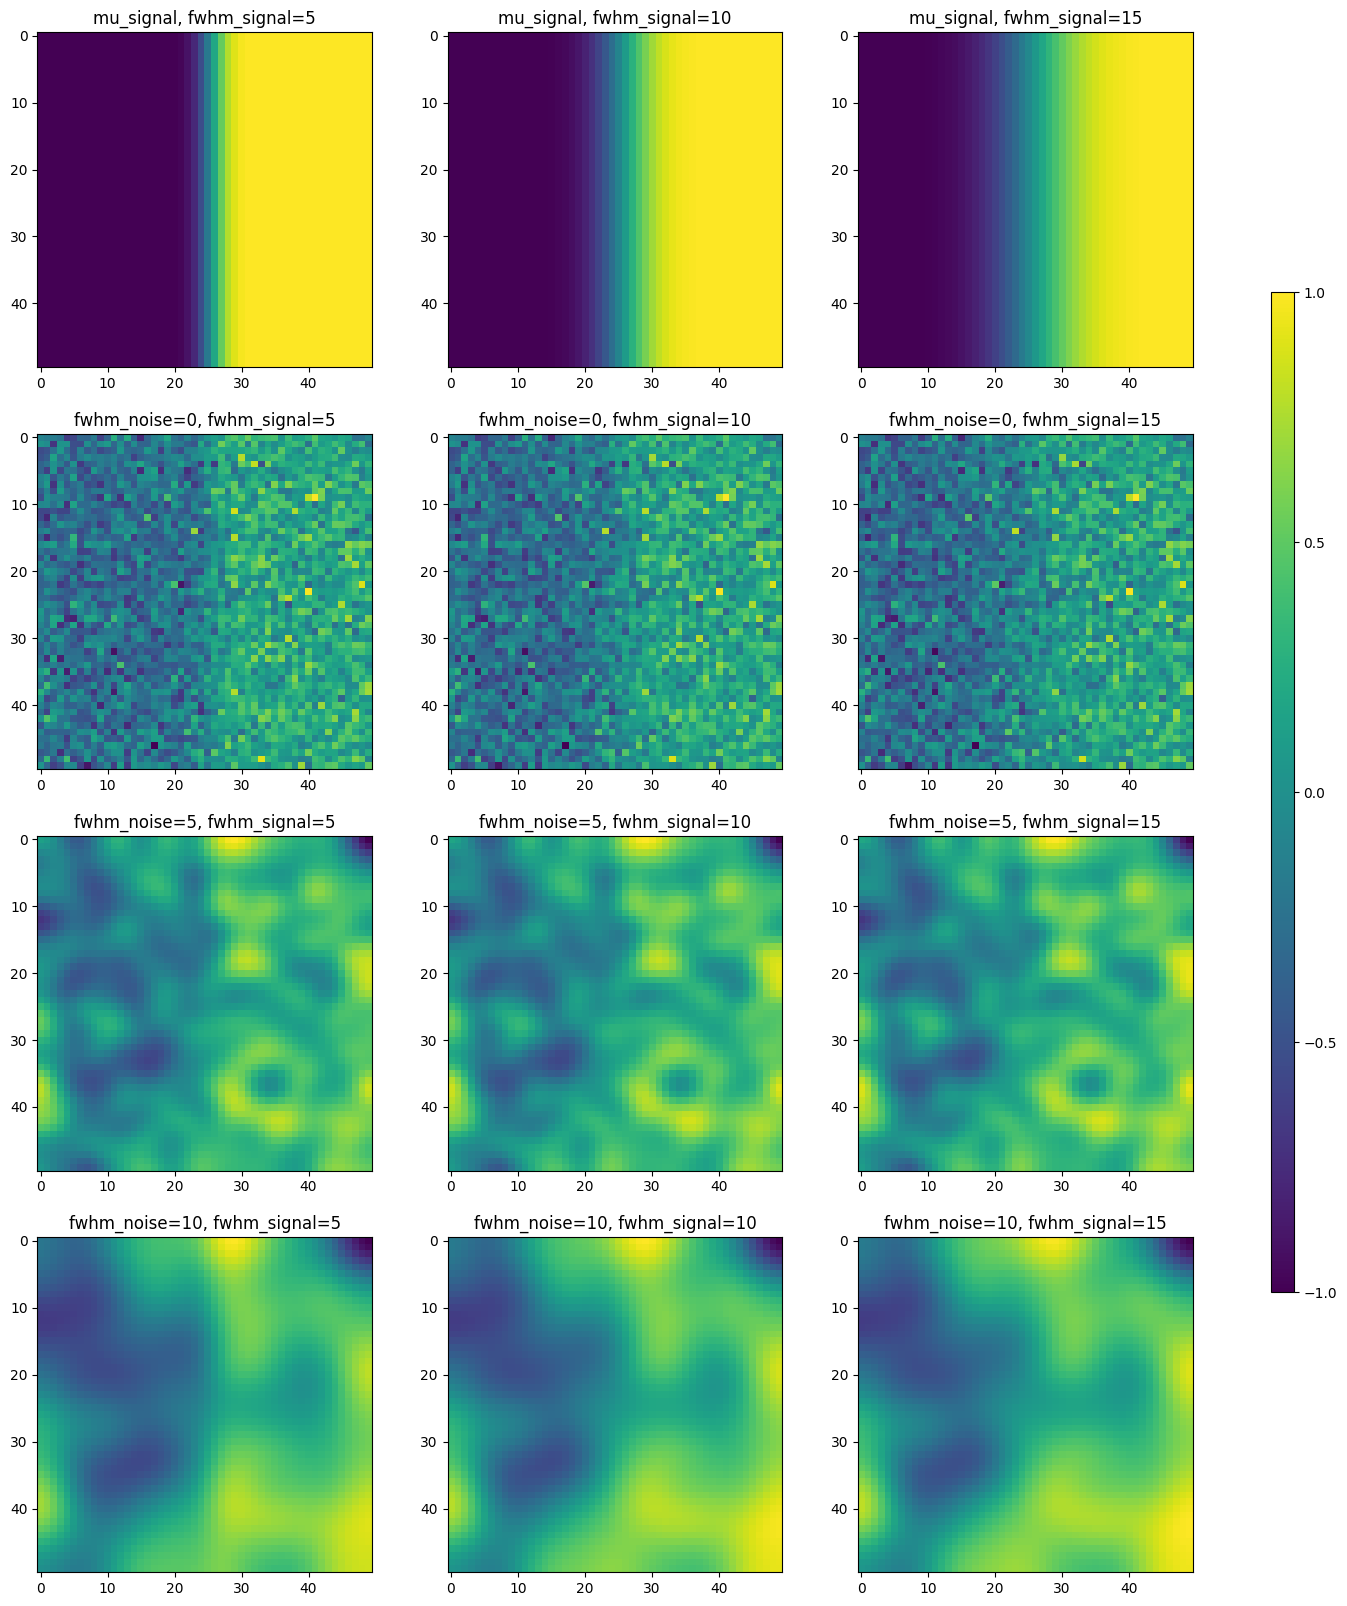

In [29]:
get_sim_signal(shape="step", shape_spec=shape_spec_step, fwhm_signal_vec=fwhm_signal_vec, fwhm_noise_vec=fwhm_noise_vec)

## threshold simulation

In [162]:
fwhm_signal_vec = [5, 10, 15]
fwhm_noise_vec = [0, 5, 10]
sim_num = 1000
figsize = (17, 20)
std = 1

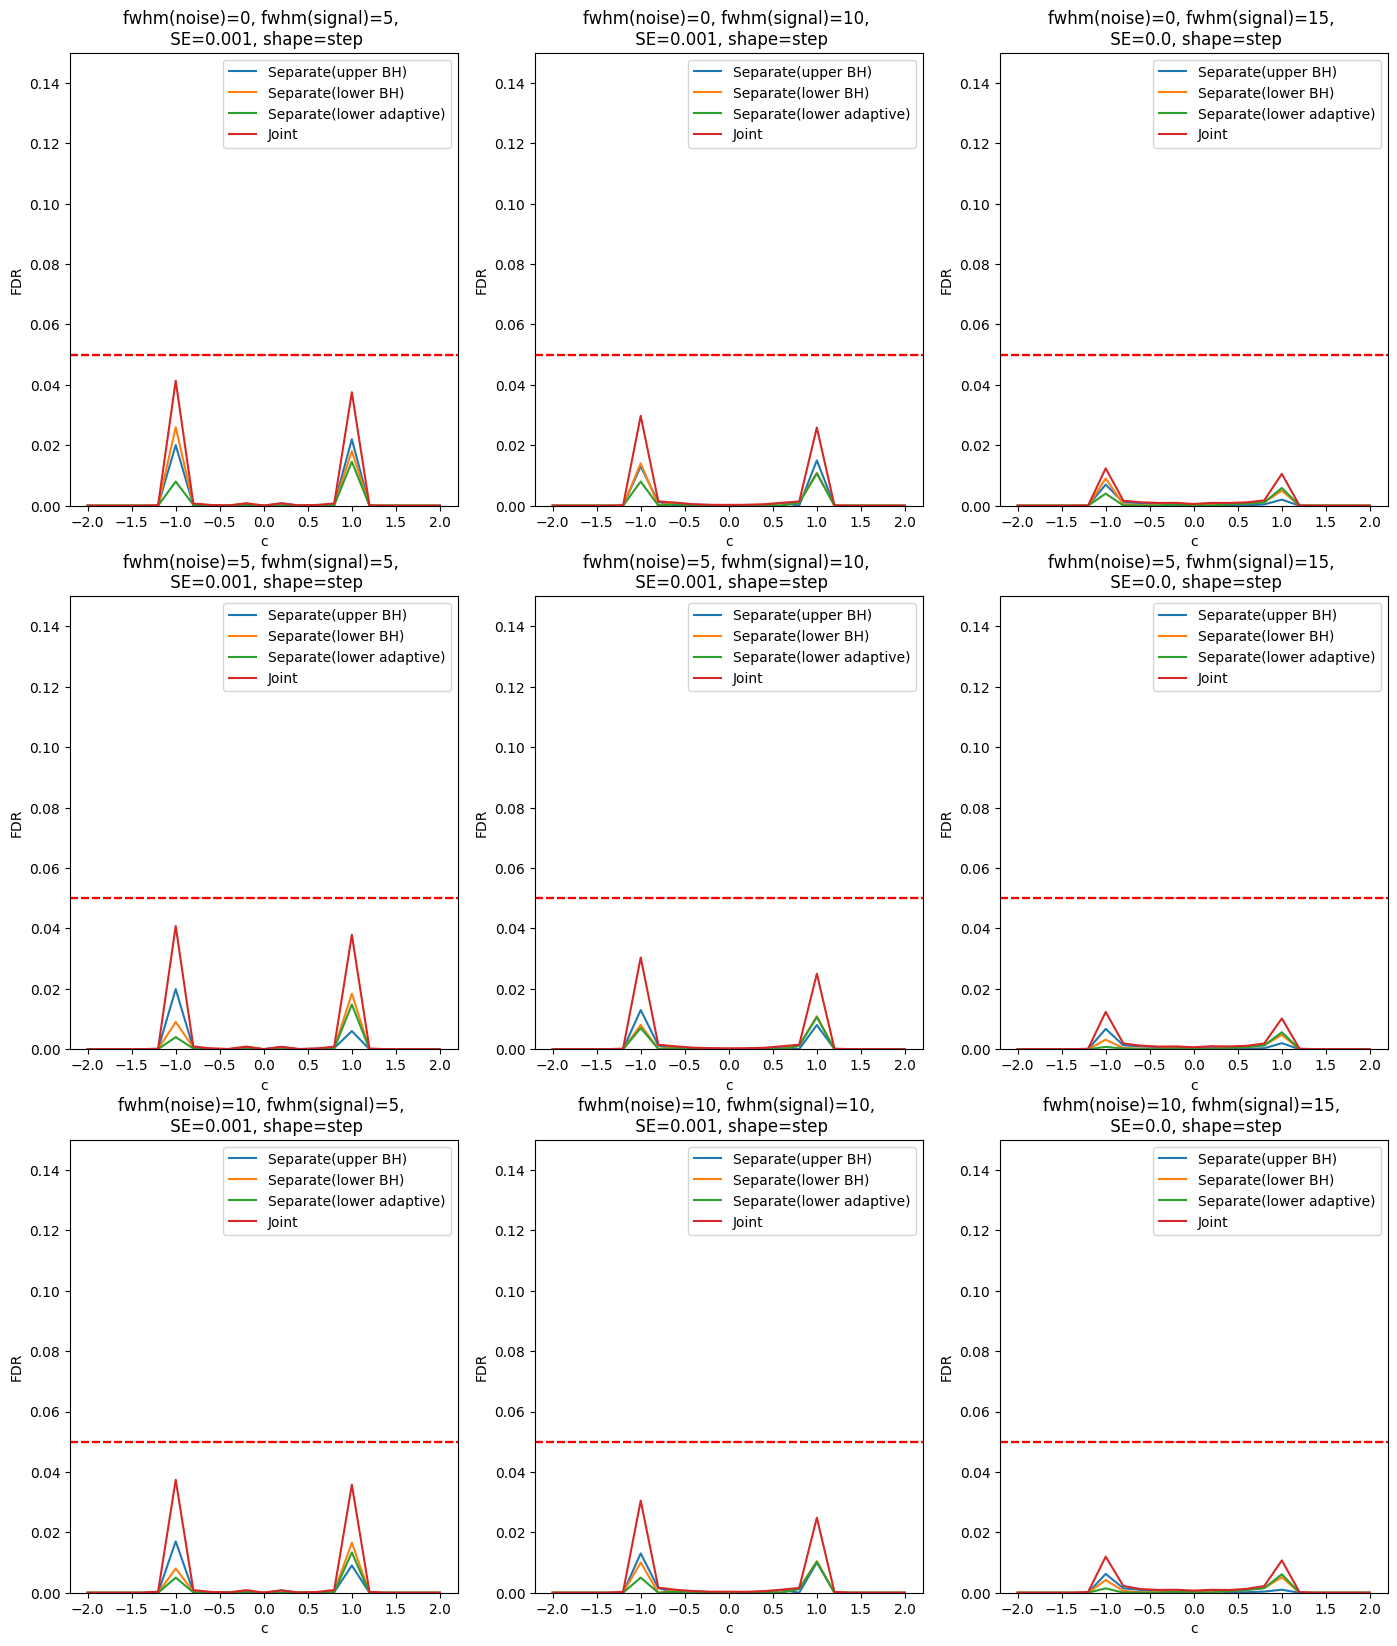

In [163]:
restart_sim = False
if restart_sim:
    FDR_step = sim_threshold(sim_num=sim_num, c=np.linspace(-2, 2, num=21), mode="FDR", shape="step",
                    fwhm_signal_vec=fwhm_signal_vec, fwhm_noise_vec=fwhm_noise_vec, std=std,
                            alpha=0.05,  figsize=figsize)
    with open('FDR_step.pkl', 'wb') as pickle_file:
        pickle.dump(FDR_step, pickle_file)


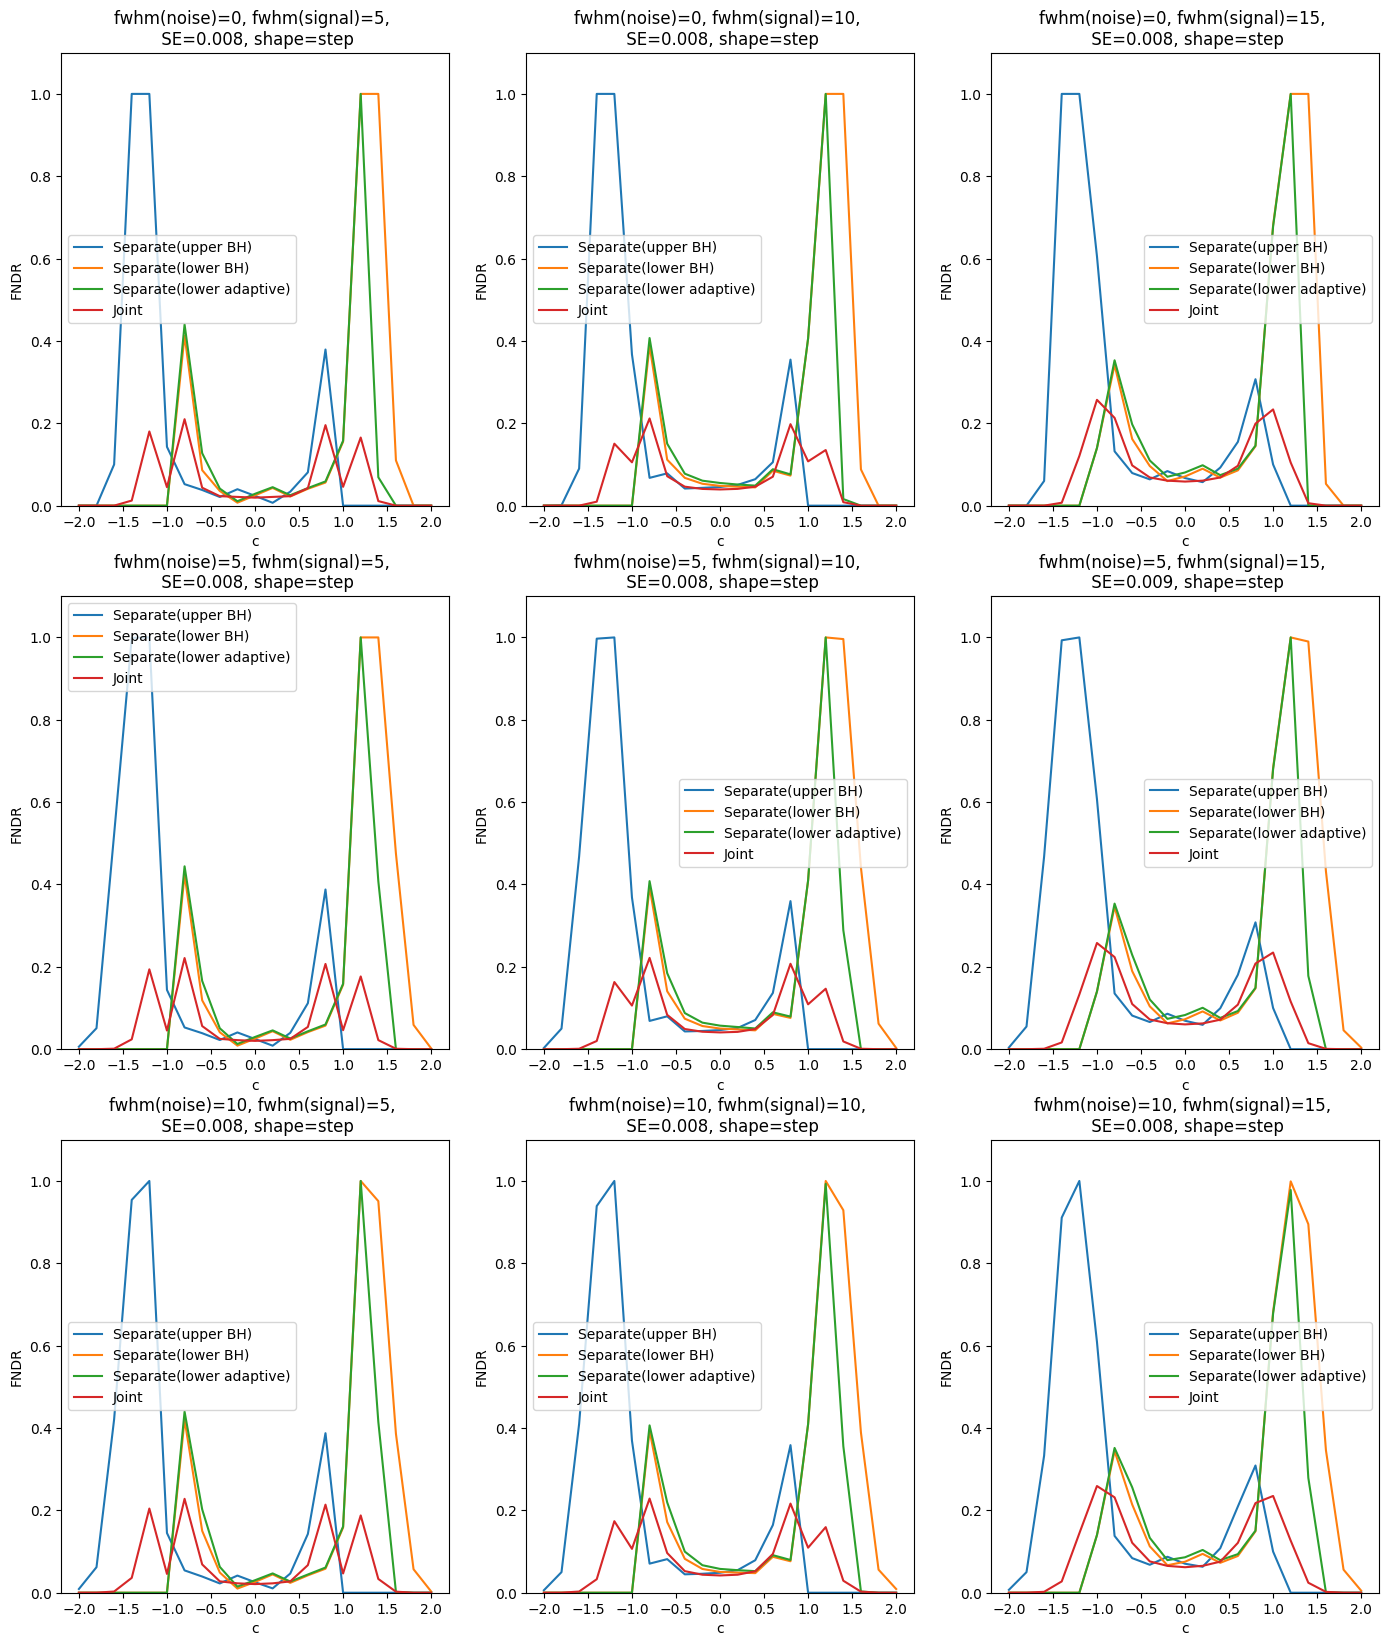

In [164]:
restart_sim = False
if restart_sim:
    FNDR_step = sim_threshold(sim_num=sim_num, c=np.linspace(-2, 2, num=21), mode="FNDR", shape="step",
                    fwhm_signal_vec=fwhm_signal_vec, fwhm_noise_vec=fwhm_noise_vec, std=std,
                        alpha=0.05, figsize=figsize)
    with open('FNDR_step.pkl', 'wb') as pickle_file:
        pickle.dump(FNDR_step, pickle_file)

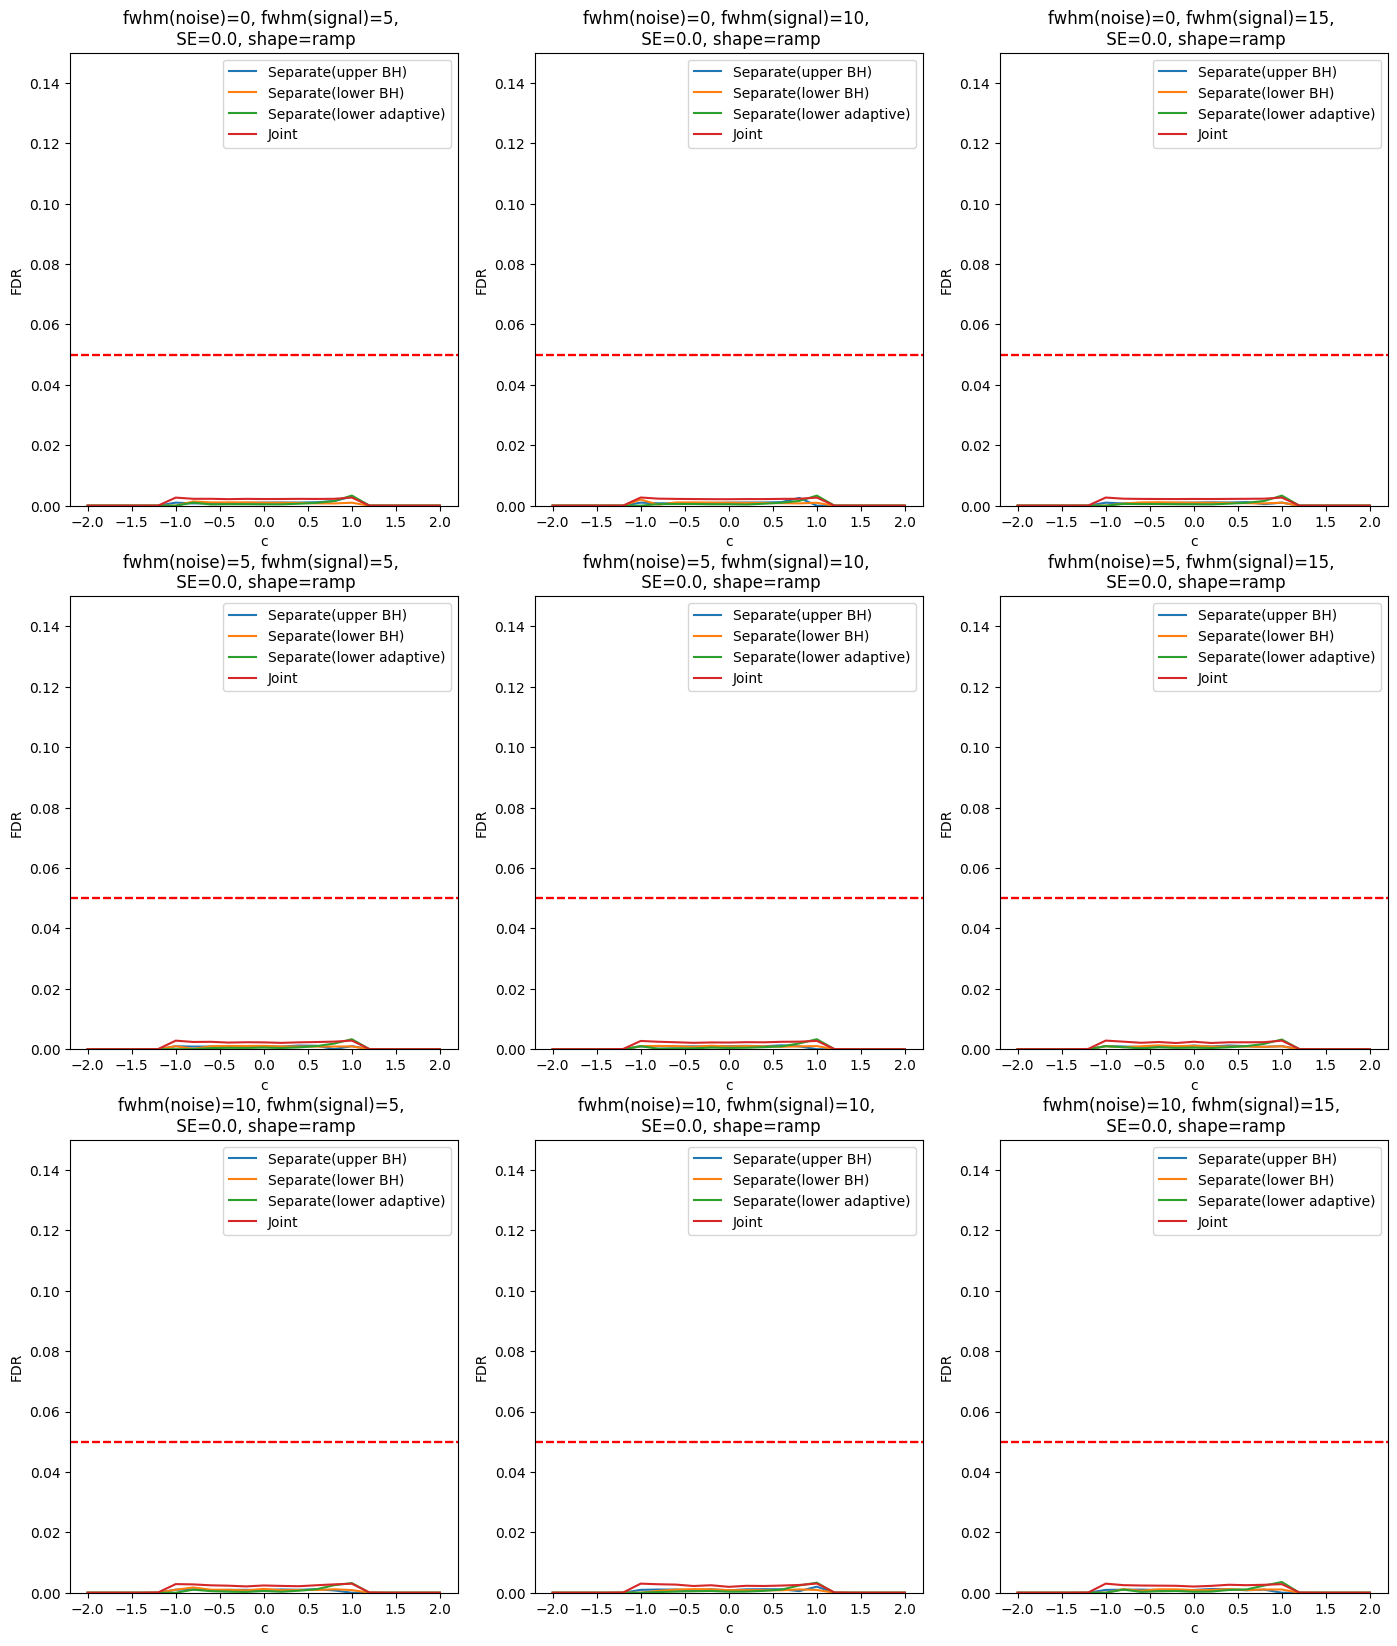

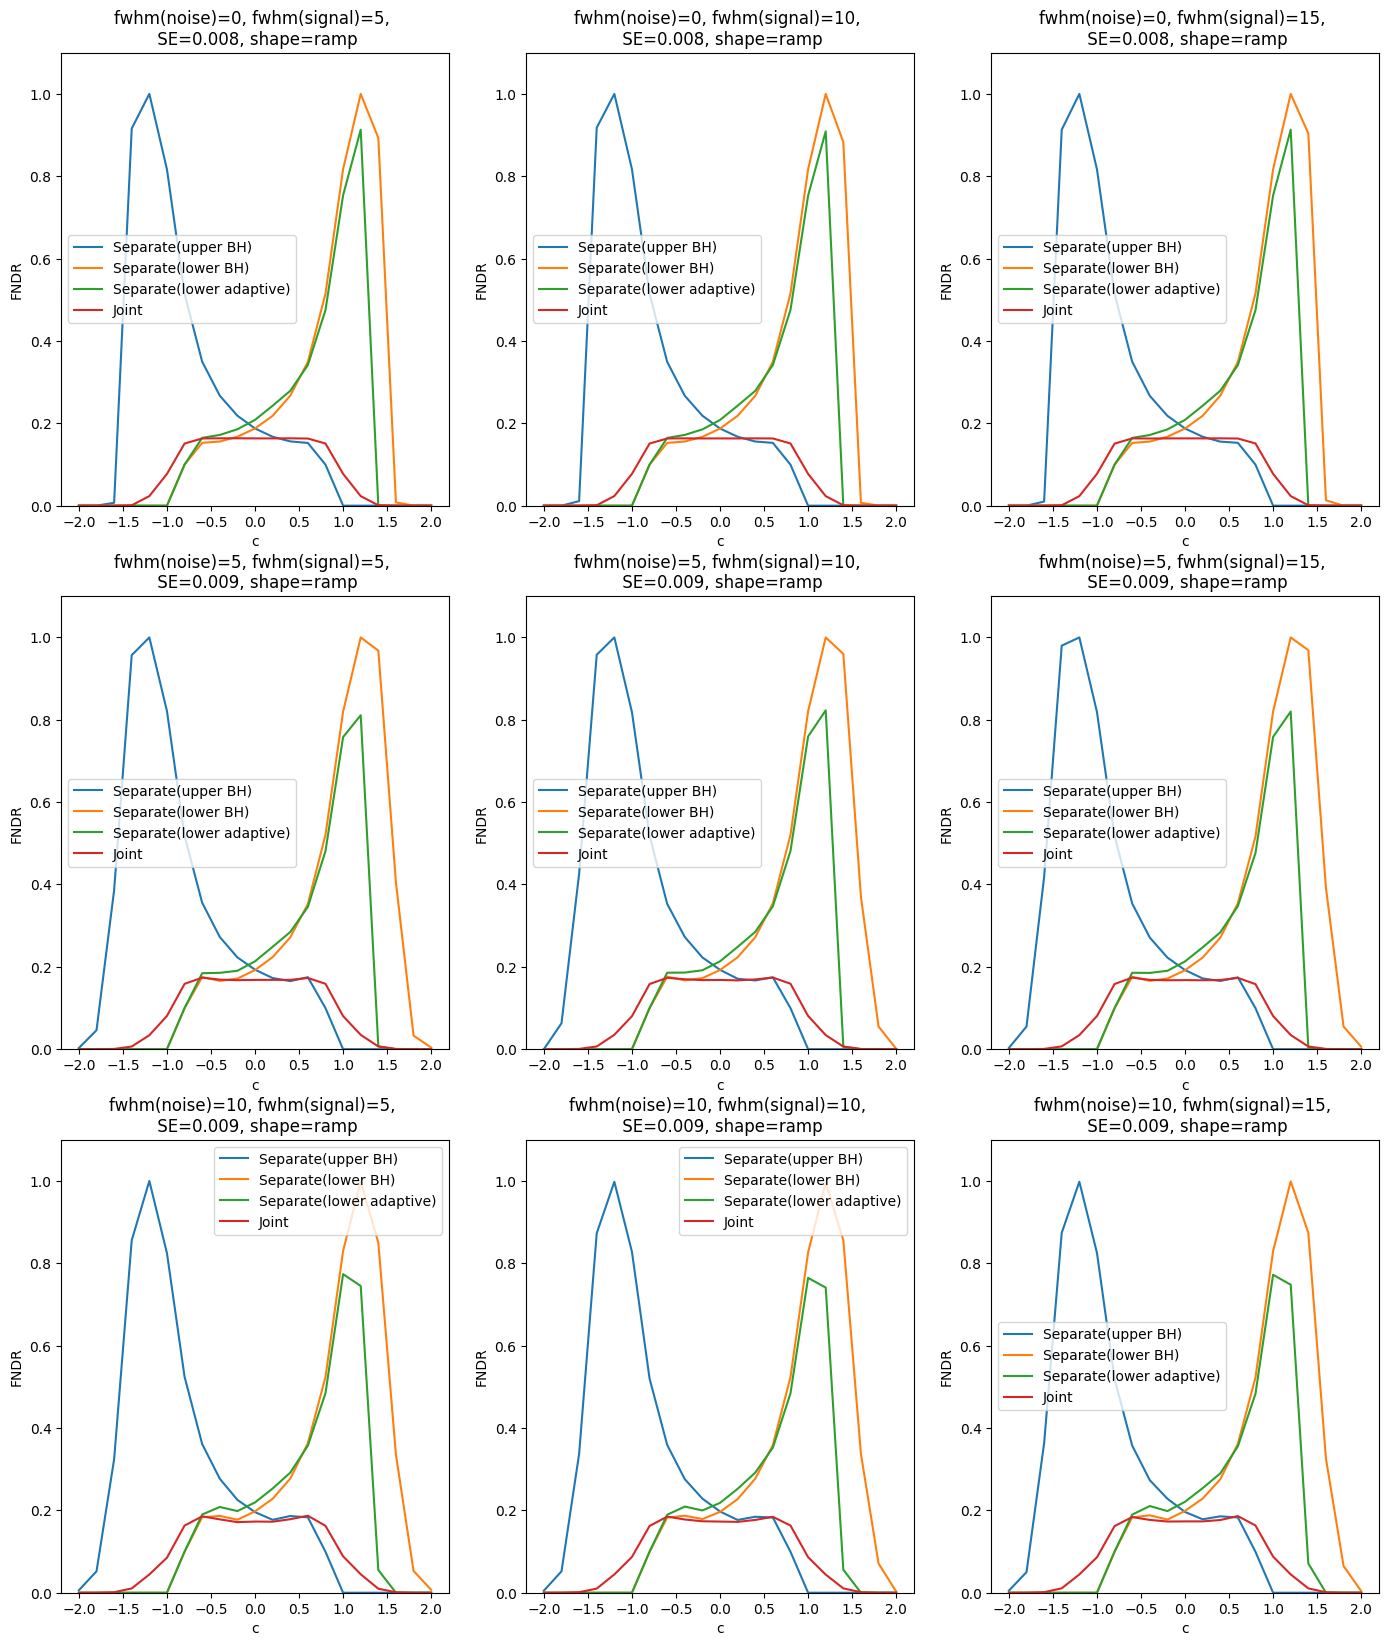

In [165]:
restart_sim = False
if restart_sim:
    FDR_ramp = sim_threshold(sim_num=sim_num, c=np.linspace(-2, 2, num=21), mode="FDR", shape="ramp",
                    fwhm_signal_vec=fwhm_signal_vec, fwhm_noise_vec=fwhm_noise_vec, std=std,
                            alpha=0.05, figsize=figsize)
    with open('FDR_ramp.pkl', 'wb') as pickle_file:
        pickle.dump(FDR_ramp, pickle_file)


    FNDR_ramp = sim_threshold(sim_num=sim_num, c=np.linspace(-2, 2, num=21), mode="FNDR", shape="ramp",
                    fwhm_signal_vec=fwhm_signal_vec, fwhm_noise_vec=fwhm_noise_vec, std=std,
                        alpha=0.05, figsize=figsize)
    with open('FNDR_ramp.pkl', 'wb') as pickle_file:
        pickle.dump(FNDR_ramp, pickle_file)

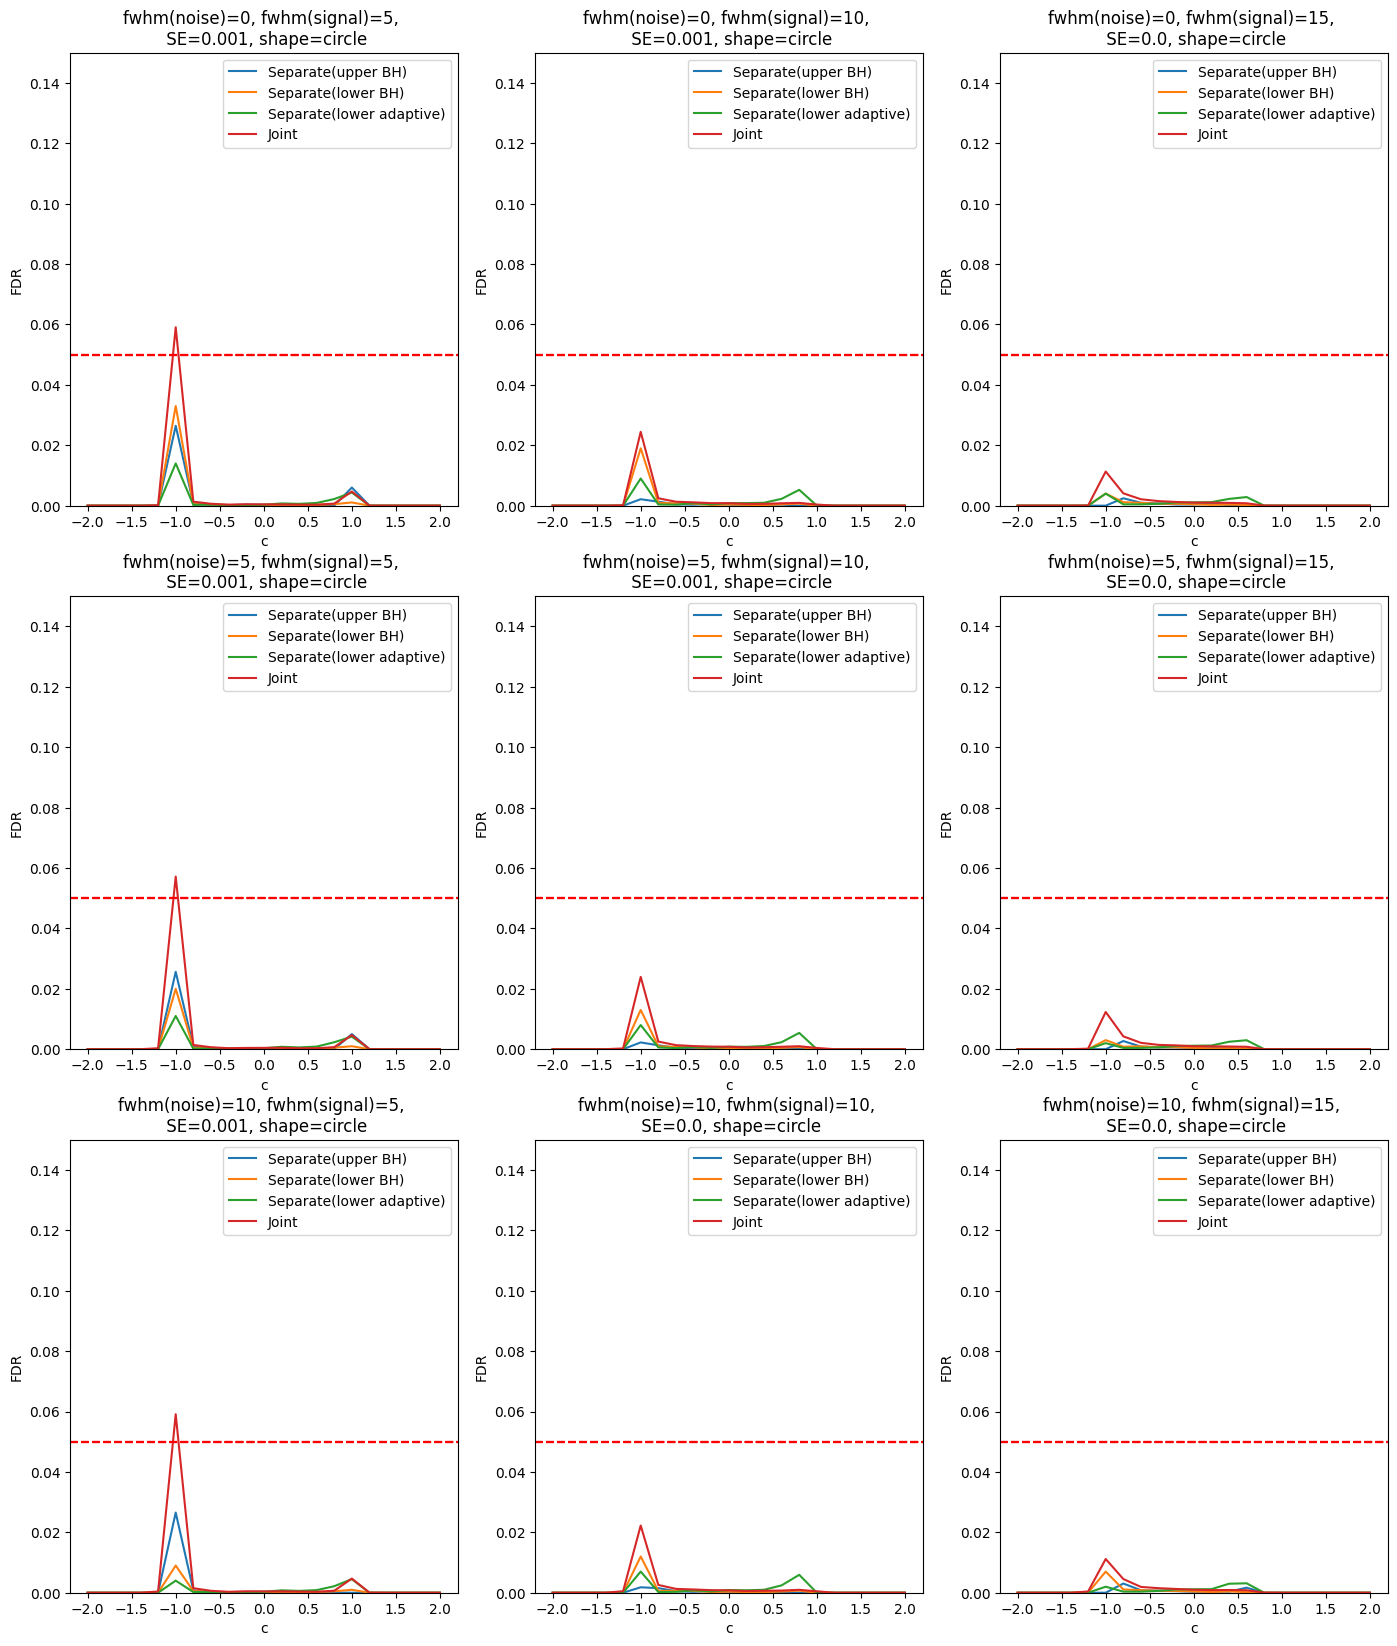

In [168]:
sim_num = 1000
FDR_circle = sim_threshold(sim_num=sim_num, c=np.linspace(-2, 2, num=21), mode="FDR", shape="circle",
                   fwhm_signal_vec=fwhm_signal_vec, fwhm_noise_vec=fwhm_noise_vec, std=std,
                        alpha=0.05,  figsize=figsize)
with open('FDR_circle.pkl', 'wb') as pickle_file:
    pickle.dump(FDR_circle, pickle_file)



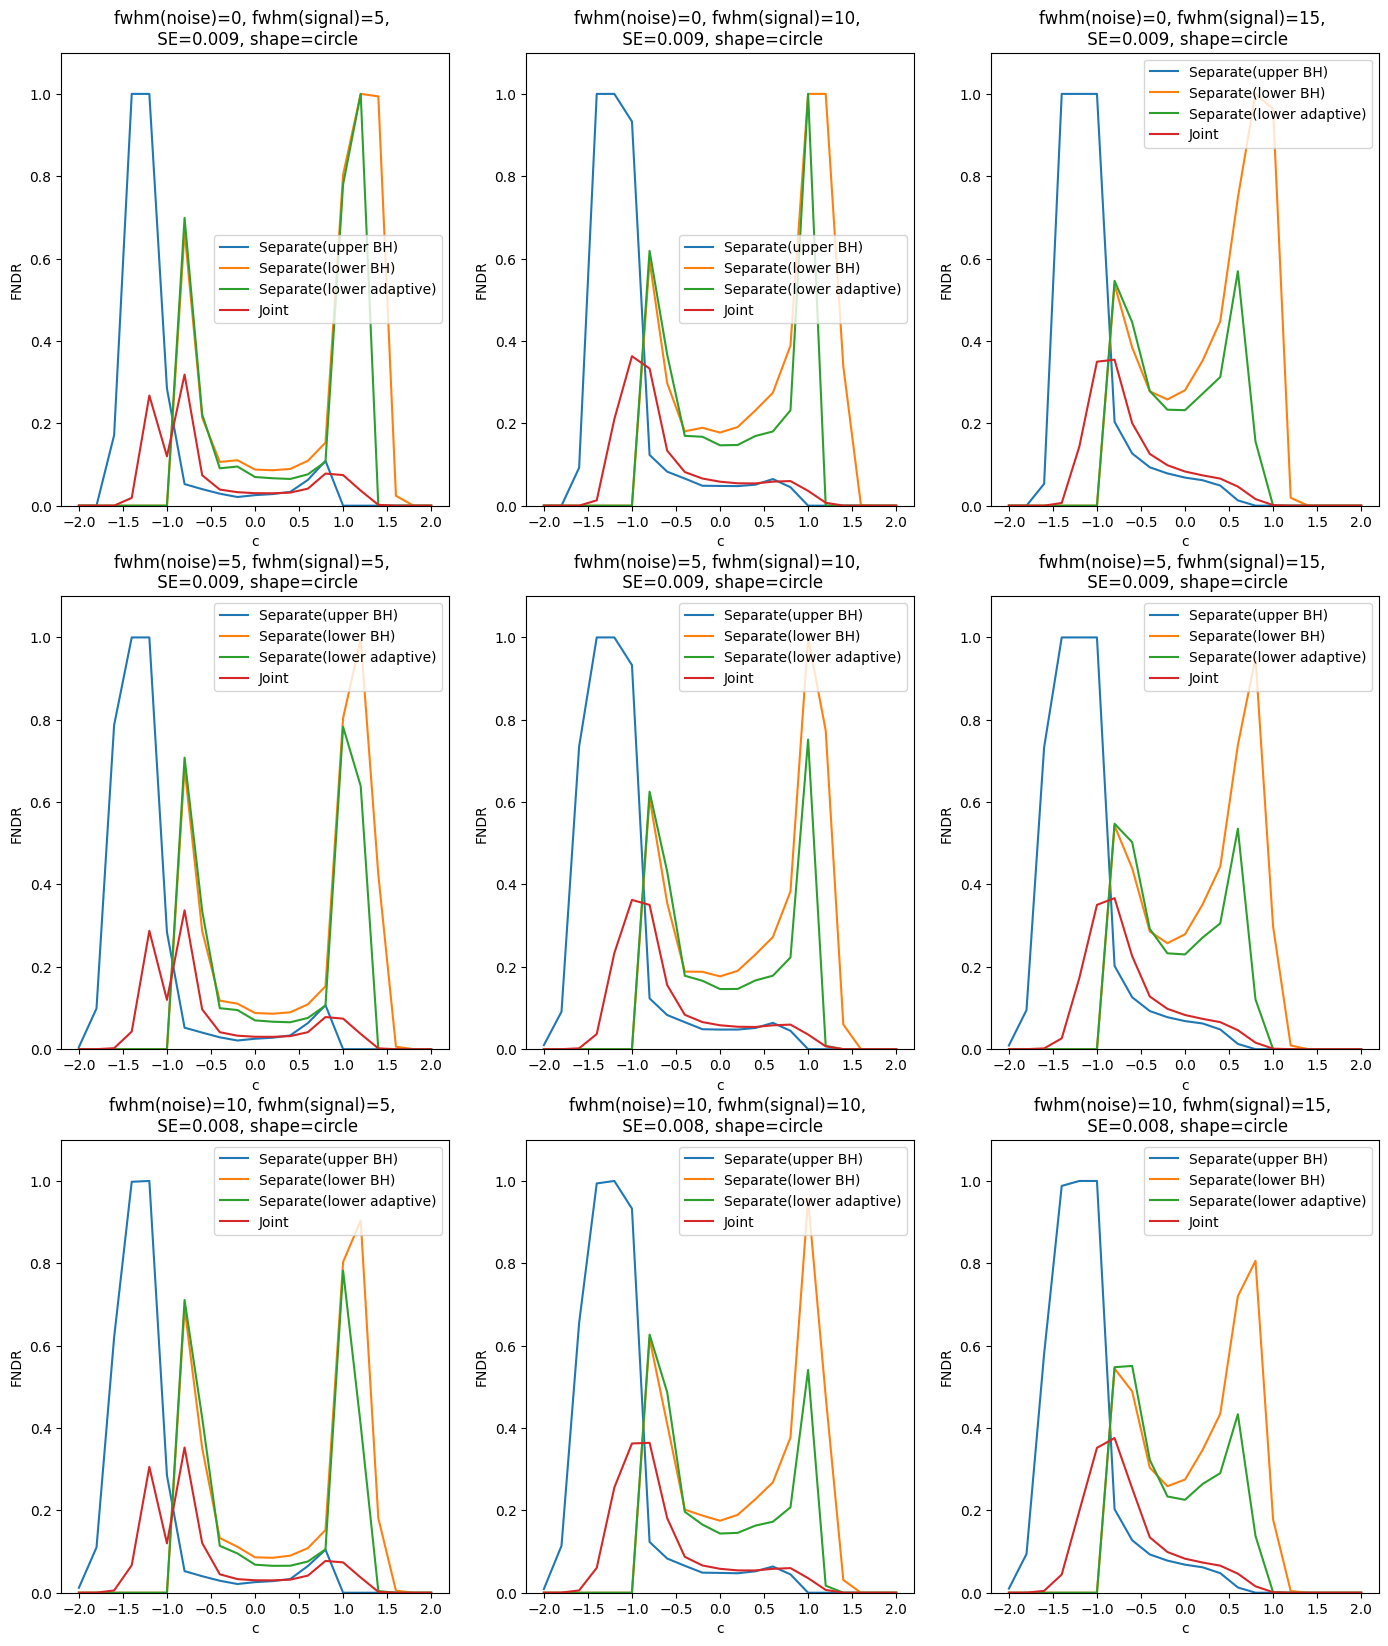

In [169]:
FNDR_circle = sim_threshold(sim_num=sim_num, c=np.linspace(-2, 2, num=21), mode="FNDR", shape="circle",
                   fwhm_signal_vec=fwhm_signal_vec, fwhm_noise_vec=fwhm_noise_vec, std=std,
                       alpha=0.05, figsize=figsize)
with open('FNDR_circle.pkl', 'wb') as pickle_file:
    pickle.dump(FNDR_circle, pickle_file)

# Plots for manuscript

In [13]:
# FDR plots
def sim_plot_individual(sim_result_dict, figsize, ylim_upper, FDR=False):
    methods_names = ['Separate(upper BH)', 'Separate(lower BH)', 'Separate(lower adaptive)', 'Joint']
    method_key = ['upper_BH', 'lower_BH', 'lower_adaptive', 'joint']
    x = np.linspace(-2, 2, num=21)
    plt.figure(figsize=figsize)
    plt.ylim(0, ylim_upper)
    for i, method in enumerate(method_key):
        plt.plot(x, sim_result_dict[method], label=methods_names[i])
        if FDR:
            plt.axhline(y=0.05, color='red', linestyle='--')
    plt.xlabel("c")
    if FDR:
        plt.ylabel("FDR")
    else:
        plt.ylabel("FNDR")
    plt.legend()
    plt.show()


In [5]:
with open('sim_result/FDR_circle.pkl', 'rb') as f:
    FDR_circle_sim = pickle.load(f)
with open('sim_result/FDR_step.pkl', 'rb') as f:
    FDR_step_sim = pickle.load(f)
with open('sim_result/FDR_ramp.pkl', 'rb') as f:
    FDR_ramp_sim = pickle.load(f)

with open('sim_result/FNDR_circle.pkl', 'rb') as f:
    FNDR_circle_sim = pickle.load(f)
with open('sim_result/FNDR_step.pkl', 'rb') as f:
    FNDR_step_sim = pickle.load(f)
with open('sim_result/FNDR_ramp.pkl', 'rb') as f:
    FNDR_ramp_sim = pickle.load(f)

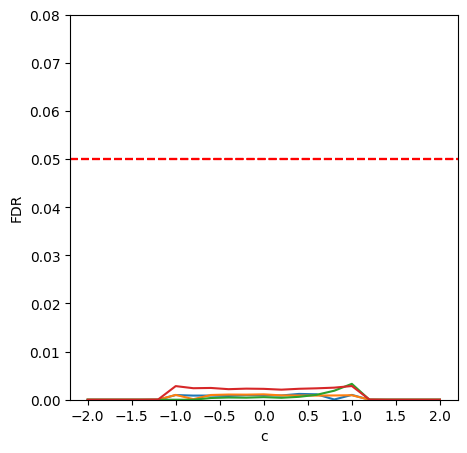

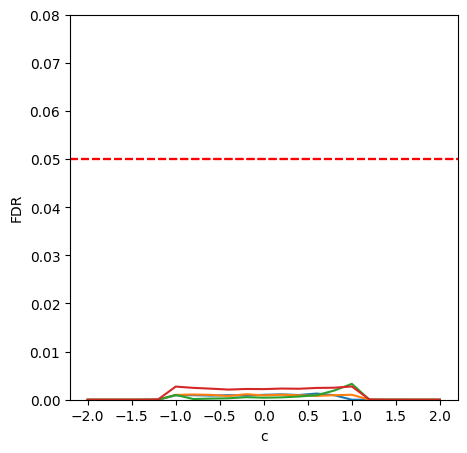

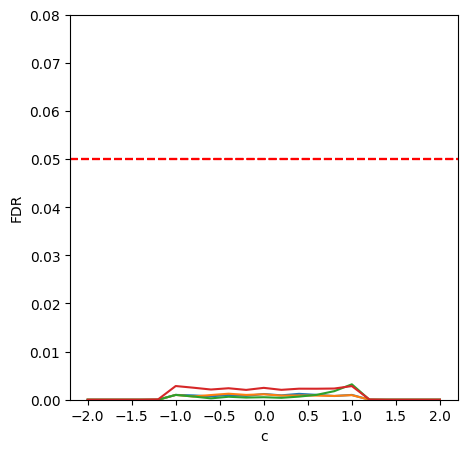

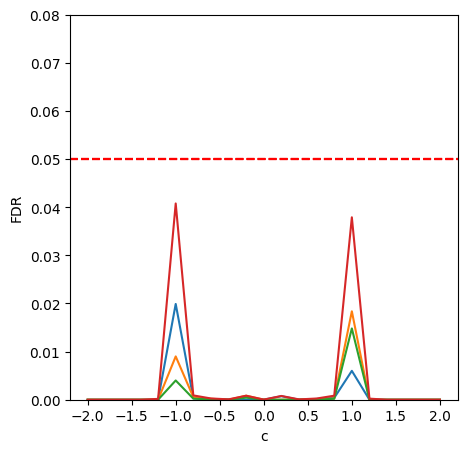

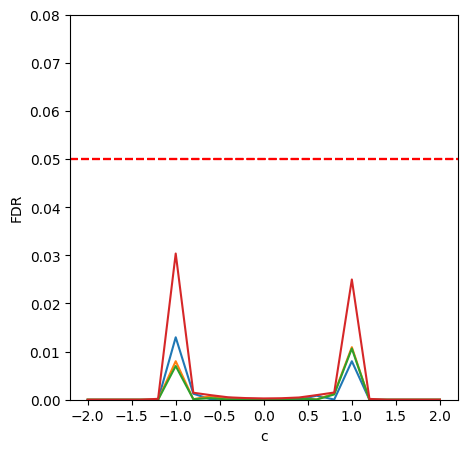

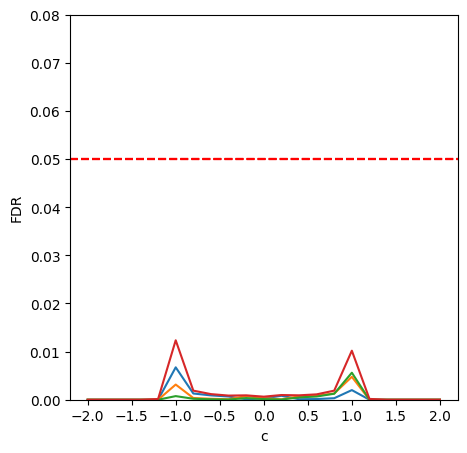

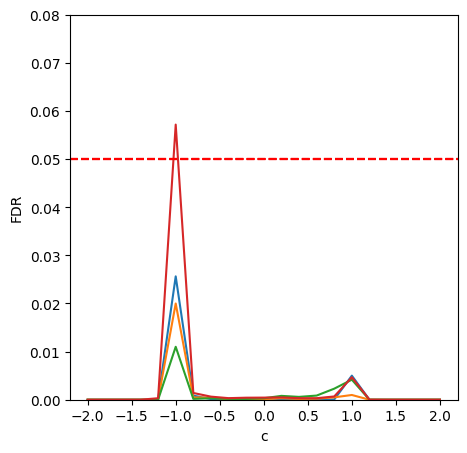

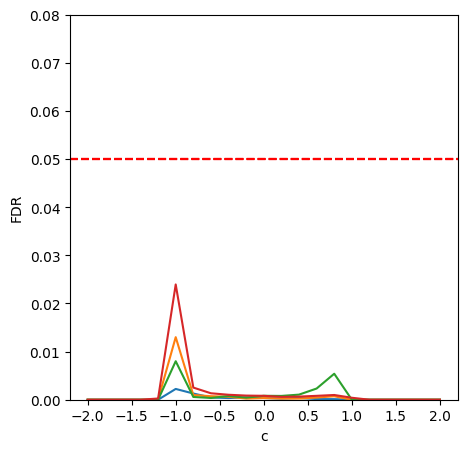

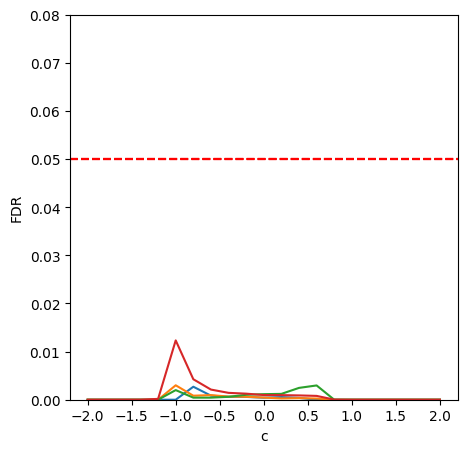

In [11]:
#FDR
figsize=(5,5)
ylim_upper = 0.08
sim_plot_individual(sim_result_dict = FDR_ramp_sim['noise5signal5'], figsize=figsize, ylim_upper=ylim_upper, FDR=True)
sim_plot_individual(sim_result_dict = FDR_ramp_sim['noise5signal10'], figsize=figsize, ylim_upper=ylim_upper, FDR=True)
sim_plot_individual(sim_result_dict = FDR_ramp_sim['noise5signal15'], figsize=figsize, ylim_upper=ylim_upper, FDR=True)
sim_plot_individual(sim_result_dict = FDR_step_sim['noise5signal5'], figsize=figsize, ylim_upper=ylim_upper, FDR=True)
sim_plot_individual(sim_result_dict = FDR_step_sim['noise5signal10'], figsize=figsize, ylim_upper=ylim_upper, FDR=True)
sim_plot_individual(sim_result_dict = FDR_step_sim['noise5signal15'], figsize=figsize, ylim_upper=ylim_upper, FDR=True)
sim_plot_individual(sim_result_dict = FDR_circle_sim['noise5signal5'], figsize=figsize, ylim_upper=ylim_upper, FDR=True)
sim_plot_individual(sim_result_dict = FDR_circle_sim['noise5signal10'], figsize=figsize, ylim_upper=ylim_upper, FDR=True)
sim_plot_individual(sim_result_dict = FDR_circle_sim['noise5signal15'], figsize=figsize, ylim_upper=ylim_upper, FDR=True)

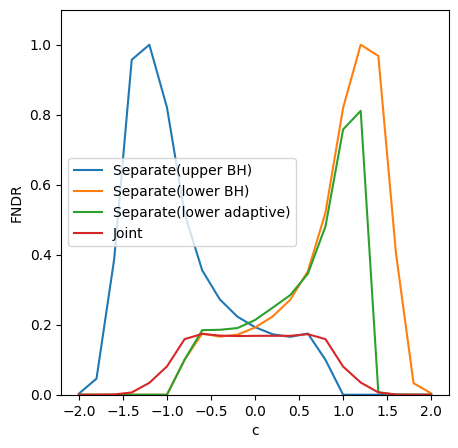

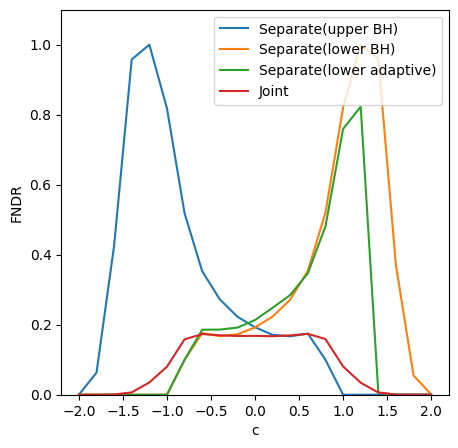

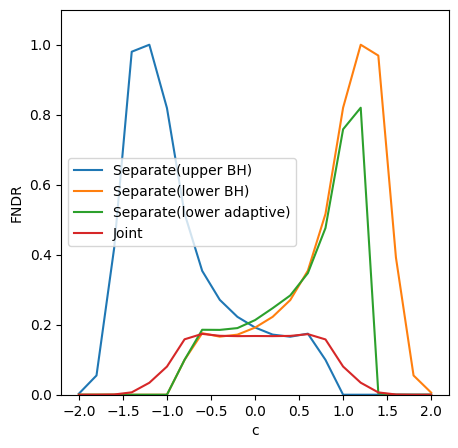

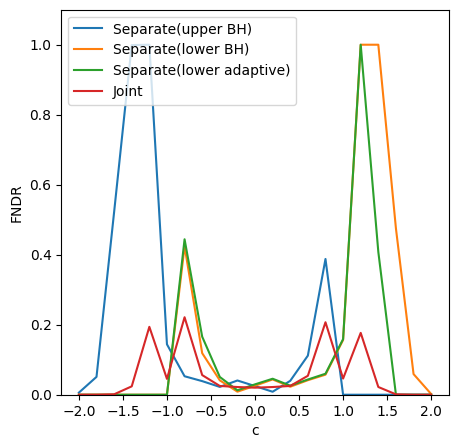

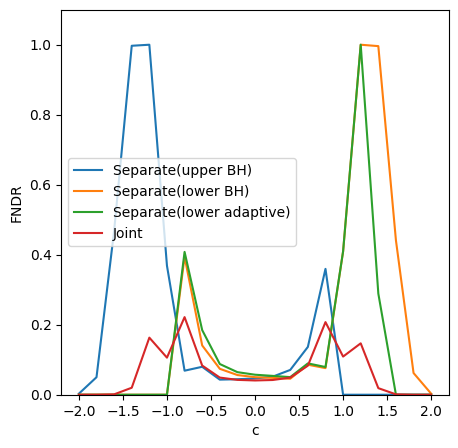

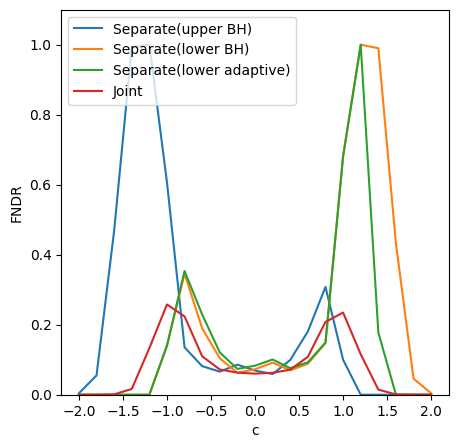

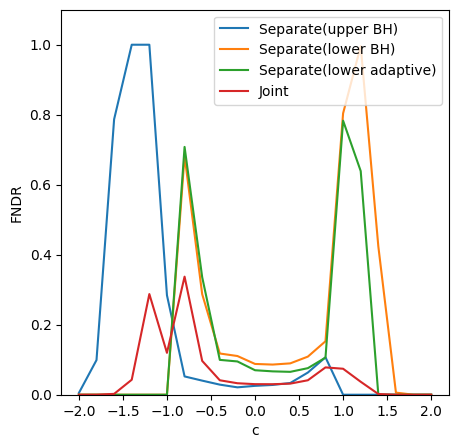

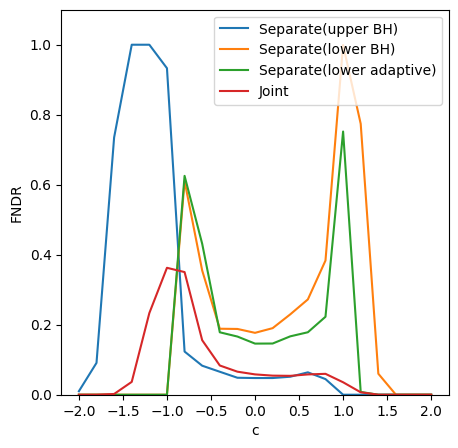

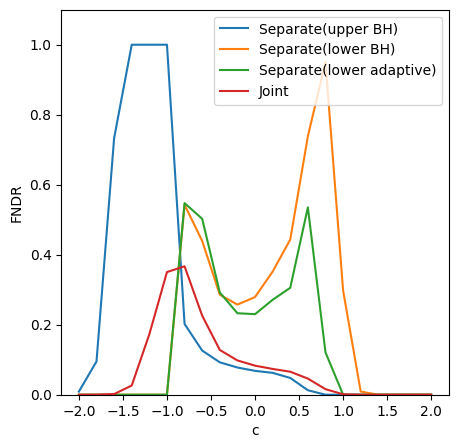

In [14]:
#FNDR
figsize=(5,5)
ylim_upper = 1.1
sim_plot_individual(sim_result_dict = FNDR_ramp_sim['noise5signal5'], figsize=figsize, ylim_upper=ylim_upper, FDR=False)
sim_plot_individual(sim_result_dict = FNDR_ramp_sim['noise5signal10'], figsize=figsize, ylim_upper=ylim_upper, FDR=False)
sim_plot_individual(sim_result_dict = FNDR_ramp_sim['noise5signal15'], figsize=figsize, ylim_upper=ylim_upper, FDR=False)
sim_plot_individual(sim_result_dict = FNDR_step_sim['noise5signal5'], figsize=figsize, ylim_upper=ylim_upper, FDR=False)
sim_plot_individual(sim_result_dict = FNDR_step_sim['noise5signal10'], figsize=figsize, ylim_upper=ylim_upper, FDR=False)
sim_plot_individual(sim_result_dict = FNDR_step_sim['noise5signal15'], figsize=figsize, ylim_upper=ylim_upper, FDR=False)
sim_plot_individual(sim_result_dict = FNDR_circle_sim['noise5signal5'], figsize=figsize, ylim_upper=ylim_upper, FDR=False)
sim_plot_individual(sim_result_dict = FNDR_circle_sim['noise5signal10'], figsize=figsize, ylim_upper=ylim_upper, FDR=False)
sim_plot_individual(sim_result_dict = FNDR_circle_sim['noise5signal15'], figsize=figsize, ylim_upper=ylim_upper, FDR=False)

# Real Data Application

In [13]:
import sanssouci as ss
import nilearn
import nibabel as nib

import pyperm as pr

from nilearn.image import get_data, load_img
from nilearn.input_data import NiftiMasker

####### SSS
# Basic imports
import os
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd


# Imports from Confidence Regions Toolbox
from crtoolbox.generate import generate_CRs

# Import supporting functions
from crtoolbox.lib.set_theory import *
from crtoolbox.lib.boundary import *
from crtoolbox.lib.regression import *
from crtoolbox.lib.cohens import *

# Import data generation
from crtoolbox.tests.generate_2d_data import *
from crtoolbox.tests.generate_ni_data import *

# Import plotting functions
from crtoolbox.lib.display import display_crs, display_volume

# Import data download function
#from data.download import download_and_extract_zip_from_dropbox
####### SSS

import requests
import zipfile
import pandas as pd
import glob
import os

def download_and_extract_zip_from_dropbox(local_path):

    url = 'https://www.dropbox.com/s/ukpxm38n0tzbw5q/HCP_U77_WM.zip?dl=1'

    # Download the zip file from Dropbox
    response = requests.get(url, allow_redirects=True)

    # Save the zip file
    zip_file_path = local_path + '.zip'

    # Write the zip file to the local path
    open(zip_file_path, 'wb').write(response.content)

    # Extract the zip file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(local_path)

    # Remove the zip file
    os.remove(zip_file_path)

    # List all nifti files in the directory
    bold_files = glob.glob(os.path.join(local_path,'HCP_U77_WM','*.nii.gz'))

    # Now sort the bold files
    bold_files = sorted(bold_files, key=lambda name: int(os.path.basename(name).split('_')[0]))

    # Read in the covariate data
    covariates = pd.read_csv(os.path.join(local_path,'HCP_U77_WM','behavioural_data_subset_77.csv'))

    # Sort dataframe by 'Subject'
    covariates = covariates.sort_values(by='Subject')

    return(bold_files, covariates)

## Load Image

In [11]:
# Real data directory
data_dir = os.path.join('/Users/howonryu/Projects/ConfidenceSet/ConfidenceSet/','data')
real_data_dir = os.path.join('/Users/howonryu/Projects/ConfidenceSet/ConfidenceSet/','data','example_real_data')

#bold_files, covariates = download_and_extract_zip_from_dropbox(real_data_dir)
data_loc = real_data_dir + '/HCP_U77_WM/'


In [12]:
# Only need to run if you already had the data downloaded:
data_loc = real_data_dir + '/HCP_U77_WM/'
bold_files = pr.list_files(data_loc, '.nii.gz', 1)


### Load all images

In [4]:
# file names
folder_path = "/Users/howonryu/Projects/ConfidenceSet/ConfidenceSet/data/example_real_data/HCP_U77_WM"
file_list = [f for f in os.listdir(folder_path) if f.endswith('.nii.gz')]

# mask
fwhm=5
mask_img = nib.load('/Users/howonryu/Projects/ConfidenceSet/ConfidenceSet/data/MNImask.nii')
masker = NiftiMasker(smoothing_fwhm=fwhm, mask_img=mask_img).fit()


img_data_stack = np.empty((91, 109, 91, len(file_list)))
masked_data_stack = np.empty((1, 228483, len(file_list)))

# additional smoothing
sigma_signal = 2.25 / np.sqrt(8 * np.log(2))
add_smoothing = False

# Load each file and append it to the list
for i, file_name in enumerate(file_list):
    file_path = os.path.join(folder_path, file_name)
    img = nib.load(file_path)
    img_data = img.get_fdata()
    masked_data = masker.transform(img)

    # if additional smoothing necessary
    if add_smoothing:
        img_data_smoothed = gaussian_filter(img, sigma=sigma_signal)
        img_smoothed = nilearn.image.smooth_img(img, fwhm=2.25)
        masked_data = masker.transform(img_smoothed)

    img_data_stack[:,:,:,i] = img_data
    masked_data_stack[:,:,i] = masked_data
masked_data_stack_unsqueezed = masked_data_stack[0,:,:]


print(img_data_stack.shape)
print(masked_data_stack.shape)
print(masked_data_stack_unsqueezed.shape)

#data_back = get_data(masker.inverse_transform((masked_data_stack_unsqueezed).transpose()))
data_back_smoothed = get_data(masker.inverse_transform((masked_data_stack_unsqueezed).transpose()))
print(data_back_smoothed.shape)



(91, 109, 91, 77)
(1, 228483, 77)
(228483, 77)
(91, 109, 91, 77)


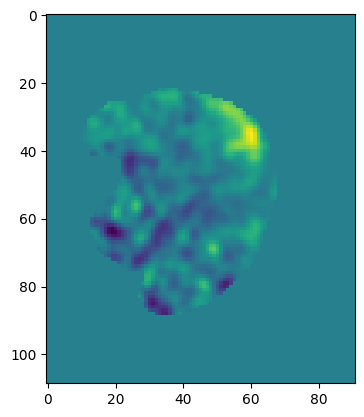

In [5]:
plt.imshow(data_back_smoothed[20,:,:,0])

(91, 109, 91)


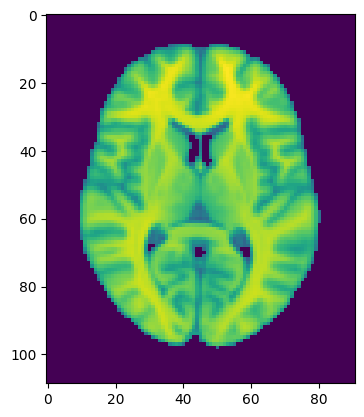

In [6]:
# brain background image
from nilearn.plotting import plot_img, plot_stat_map, view_img
from nilearn.image import get_data, load_img

background = get_data('/Users/howonryu/Projects/ConfidenceSet/ConfidenceSet/data/MNIbrain.nii.gz')
print(background.shape)


plt.imshow(np.rot90(background[:,:,40], k=1))
plt.show()



Find the new indices from [-32, 24, 2]

In [9]:
# Find coordinates
values = [[-2, 0, 0, 92],
    [0, 2, 0, -128],
    [0, 0, 2, -74],
    [0, 0, 0, 1]]

v_mat = np.array(values)


data = data_back_smoothed

#idx_spm = np.linalg.solve(v_mat, [-32, 24, 2, 1])
idx_spm = np.linalg.solve(v_mat, [-4, 16, 48, 1])
idx_fsl = idx_spm - 1
sag_x_slice, cor_y_slice, axi_z_slice, _ = idx_fsl.astype(int)

print(idx_fsl)

# FDR prep

sagittal = np.rot90(np.transpose(data[sag_x_slice,:,:,:], (2, 0, 1)), k=1, axes=(1,2))
sagittal_background = np.rot90(background[sag_x_slice,:,:], k=1)


coronal = np.rot90(np.transpose(data[:,cor_y_slice,:,:], (2, 0, 1)), k=1, axes=(1,2))
coronal_background = np.rot90(background[:,cor_y_slice,:], k=1)


axial = np.rot90(np.transpose(data[:,:,axi_z_slice,:], (2, 0, 1)), k=1, axes=(1,2))
axial_background = np.rot90(background[:,:,axi_z_slice], k=1)



#fig, axs = plt.subplots(1,3)
#axs[0].imshow(sagittal_background)
#axs[1].imshow(coronal_background)
#axs[2].imshow(axial_background)


# SSS prep
folder_path = "/Users/howonryu/Projects/ConfidenceSet/ConfidenceSet/data/example_real_data/HCP_U77_WM"
file_list = [f for f in os.listdir(folder_path) if f.endswith('.nii.gz')]
data_files = [os.path.join(folder_path, file_name) for file_name in file_list]
n = len(data_files)
X = np.ones((n,1))

out_dir = "/Users/howonryu/Projects/ConfidenceSet/ConfidenceSet/SSS_output"

muhat_file, sigma_file, resid_files = regression(data_files, X, out_dir)

[47. 71. 60.  0.]


## Confidence Set Appllication

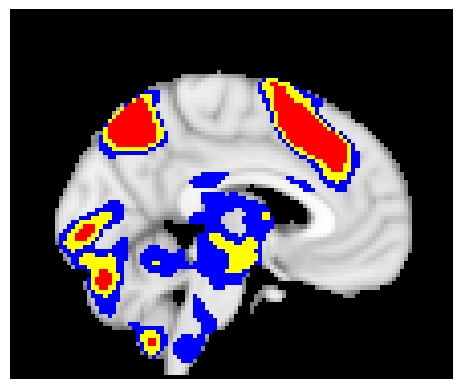

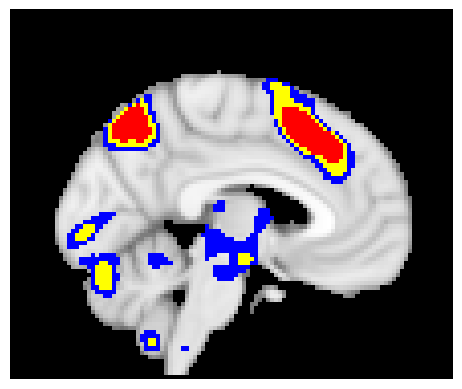

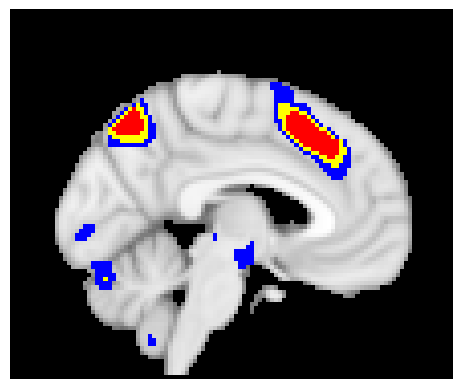

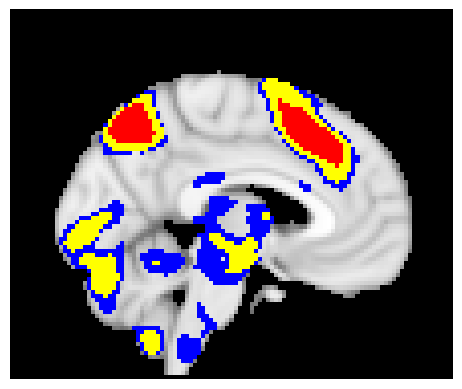

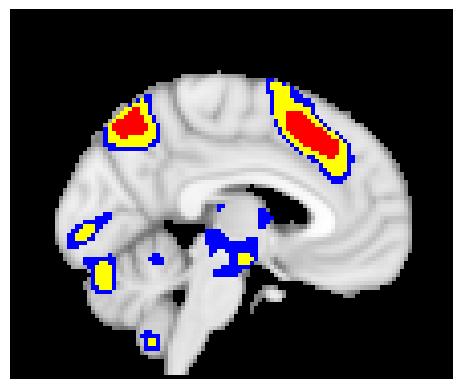

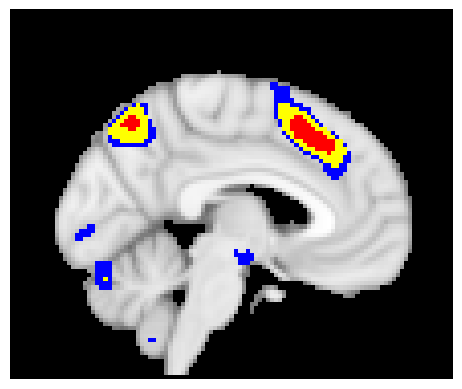

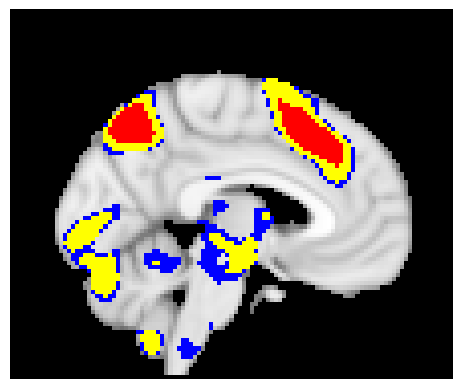

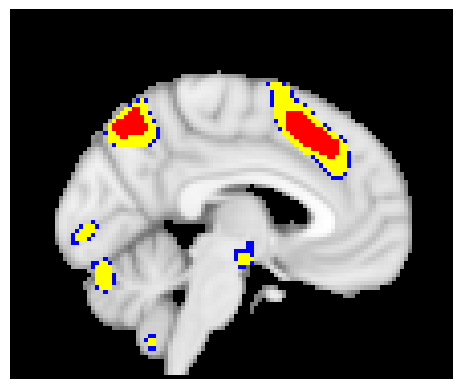

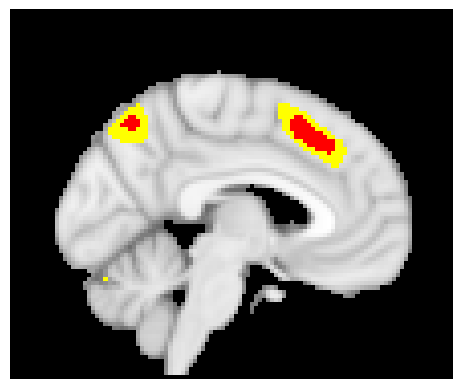

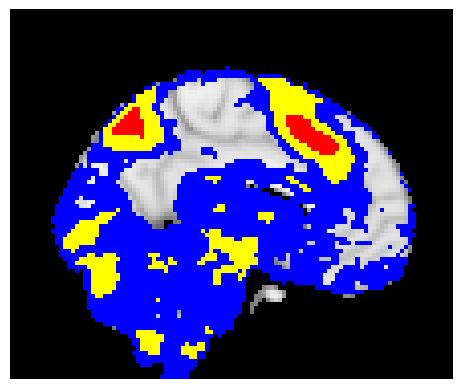

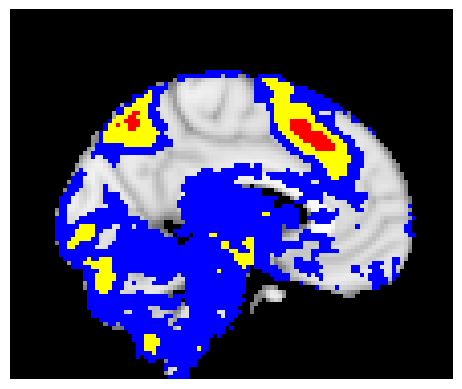

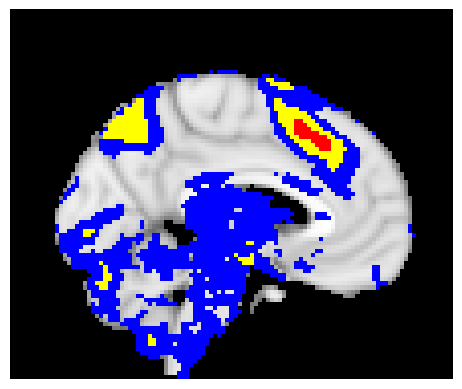

sagittal (X=-4), alpha = 0.05


In [19]:
thresholds = [10, 15, 20]
background_slc = sagittal_background
misc = "-4"
n_boot = 2000

slc_info = [sagittal, "sagittal", sag_x_slice]
plot_confset_HCP_table(thresholds, background_slc, slc_info, muhat_file, sigma_file, resid_files, misc=misc, alpha=0.05, n_boot=n_boot, figsize=(18,10), fontsize=15)

/Users/howonryu/Projects/ConfidenceSet/ConfidenceSet/confidenceset/confset.py:92: RuntimeWarning: divide by zero encountered in divide
  tstat = (np.sqrt(n_subj) * xbar) / std_dev


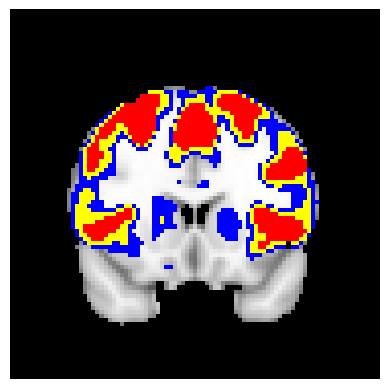

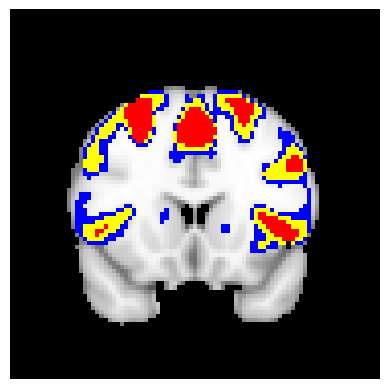

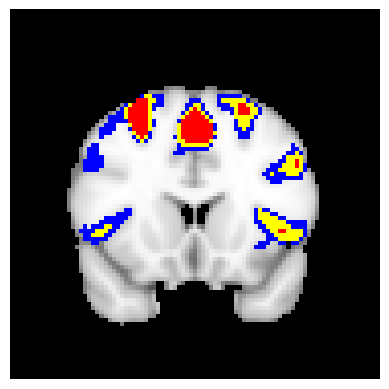

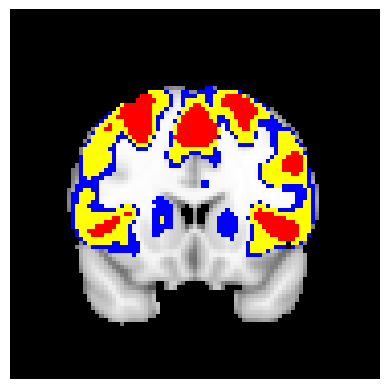

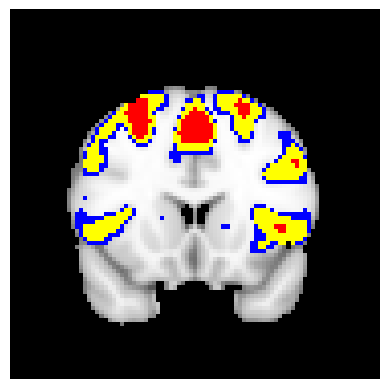

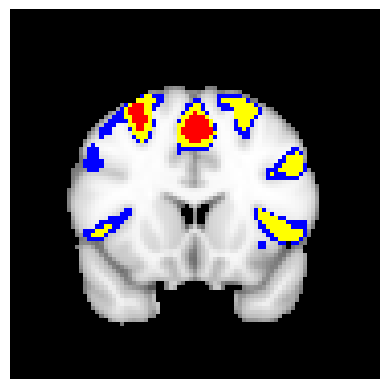

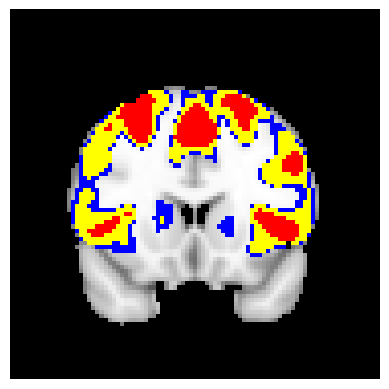

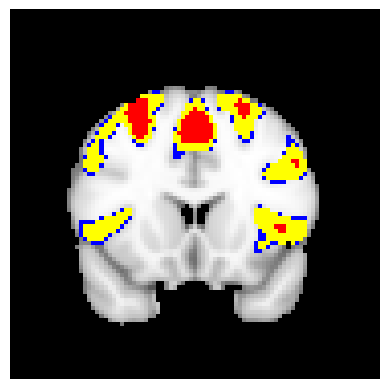

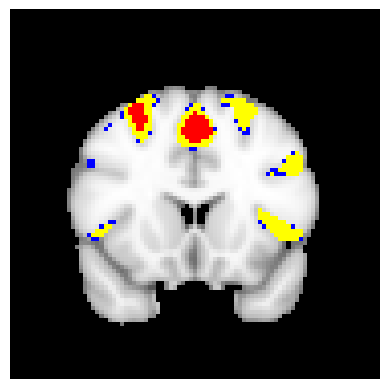

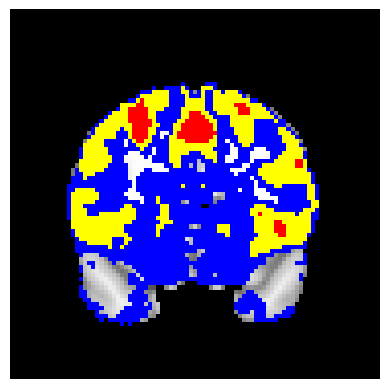

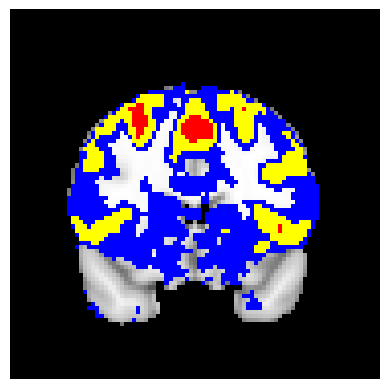

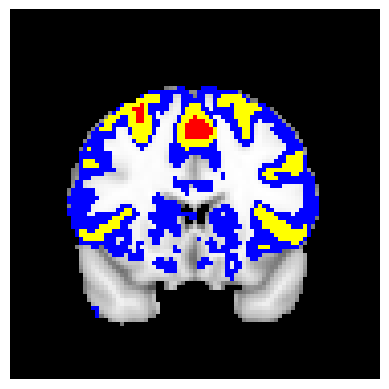

coronal (Y=16), alpha = 0.05


In [20]:
thresholds = [10, 15, 20]
misc = "16"
background_slc = coronal_background
slc_info = [coronal, "coronal", cor_y_slice]
plot_confset_HCP_table(thresholds, background_slc, slc_info, muhat_file, sigma_file, resid_files, misc=misc, alpha=0.05, n_boot=n_boot, figsize=(18,10), fontsize=15)

/Users/howonryu/Projects/ConfidenceSet/ConfidenceSet/confidenceset/confset.py:92: RuntimeWarning: divide by zero encountered in divide
  tstat = (np.sqrt(n_subj) * xbar) / std_dev


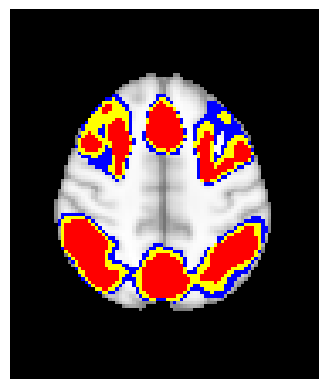

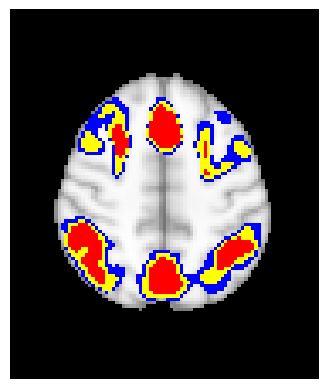

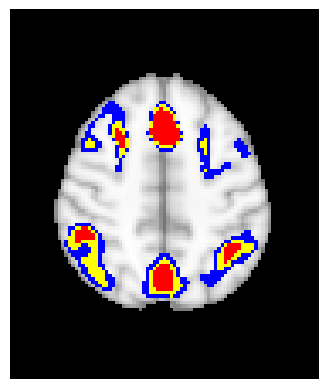

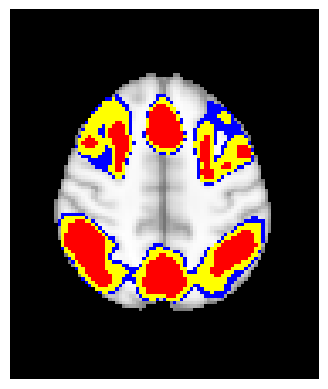

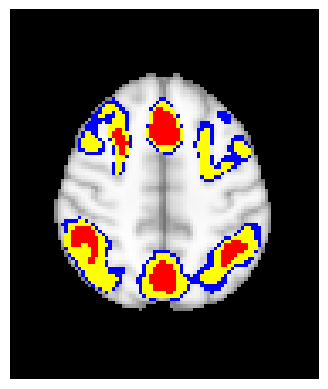

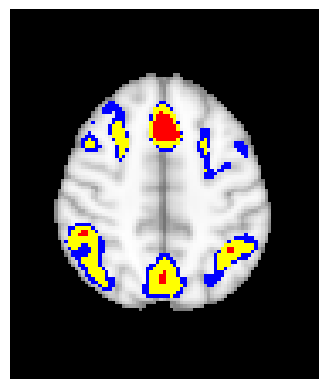

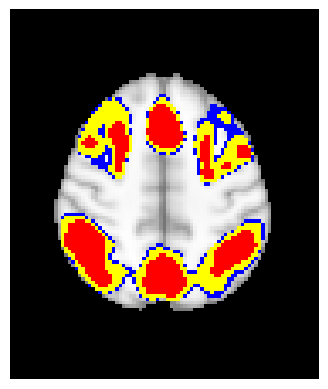

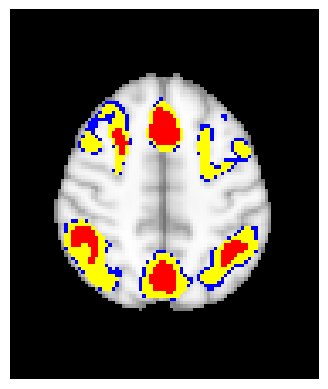

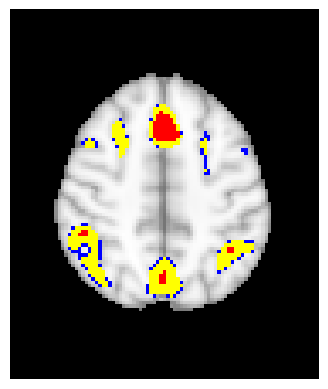

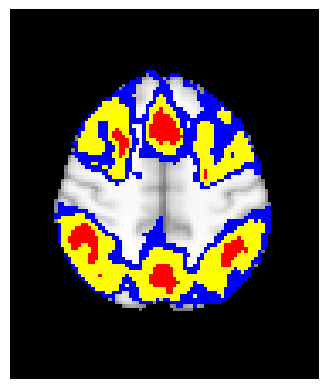

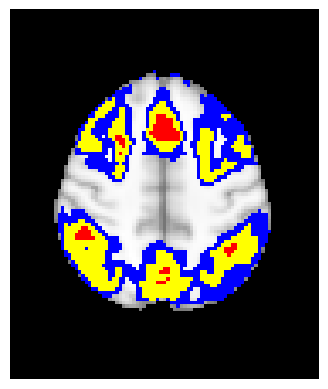

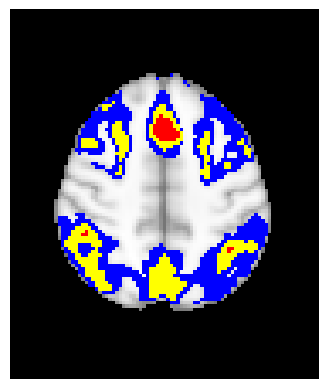

axial (Z=48), alpha = 0.05


In [21]:
thresholds = [10, 15, 20]
misc = "48"
background_slc = axial_background
slc_info = [axial, "axial", axi_z_slice]
plot_confset_HCP_table(thresholds, background_slc, slc_info, muhat_file, sigma_file, resid_files, misc=misc, alpha=0.05, n_boot=n_boot, figsize=(18,10), fontsize=15)

### Different Slices

In [106]:
# Find coordinates
values = [[-2, 0, 0, 92],
    [0, 2, 0, -128],
    [0, 0, 2, -74],
    [0, 0, 0, 1]]

v_mat = np.array(values)


data = data_back_smoothed

#idx_spm = np.linalg.solve(v_mat, [-32, 24, 2, 1])
idx_spm = np.linalg.solve(v_mat, [-4, 16, 48, 1])
idx_fcl = idx_spm - 1
sag_x_slice, cor_y_slice, axi_z_slice, _ = idx_fcl.astype(int)

print(idx_fcl)

# FDR prep

sagittal = np.rot90(np.transpose(data[sag_x_slice,:,:,:], (2, 0, 1)), k=1, axes=(1,2))
sagittal_background = np.rot90(background[sag_x_slice,:,:], k=1)


coronal = np.rot90(np.transpose(data[:,cor_y_slice,:,:], (2, 0, 1)), k=1, axes=(1,2))
coronal_background = np.rot90(background[:,cor_y_slice,:], k=1)


axial = np.rot90(np.transpose(data[:,:,axi_z_slice,:], (2, 0, 1)), k=1, axes=(1,2))
axial_background = np.rot90(background[:,:,axi_z_slice], k=1)



#fig, axs = plt.subplots(1,3)
#axs[0].imshow(sagittal_background)
#axs[1].imshow(coronal_background)
#axs[2].imshow(axial_background)


# SSS prep
folder_path = "/Users/howonryu/Projects/ConfidenceSet/ConfidenceSet/data/example_real_data/HCP_U77_WM"
file_list = [f for f in os.listdir(folder_path) if f.endswith('.nii.gz')]
data_files = [os.path.join(folder_path, file_name) for file_name in file_list]
n = len(data_files)
X = np.ones((n,1))

out_dir = "/Users/howonryu/Projects/ConfidenceSet/ConfidenceSet/SSS_output"

muhat_file, sigma_file, resid_files = regression(data_files, X, out_dir)

[47. 71. 60.  0.]


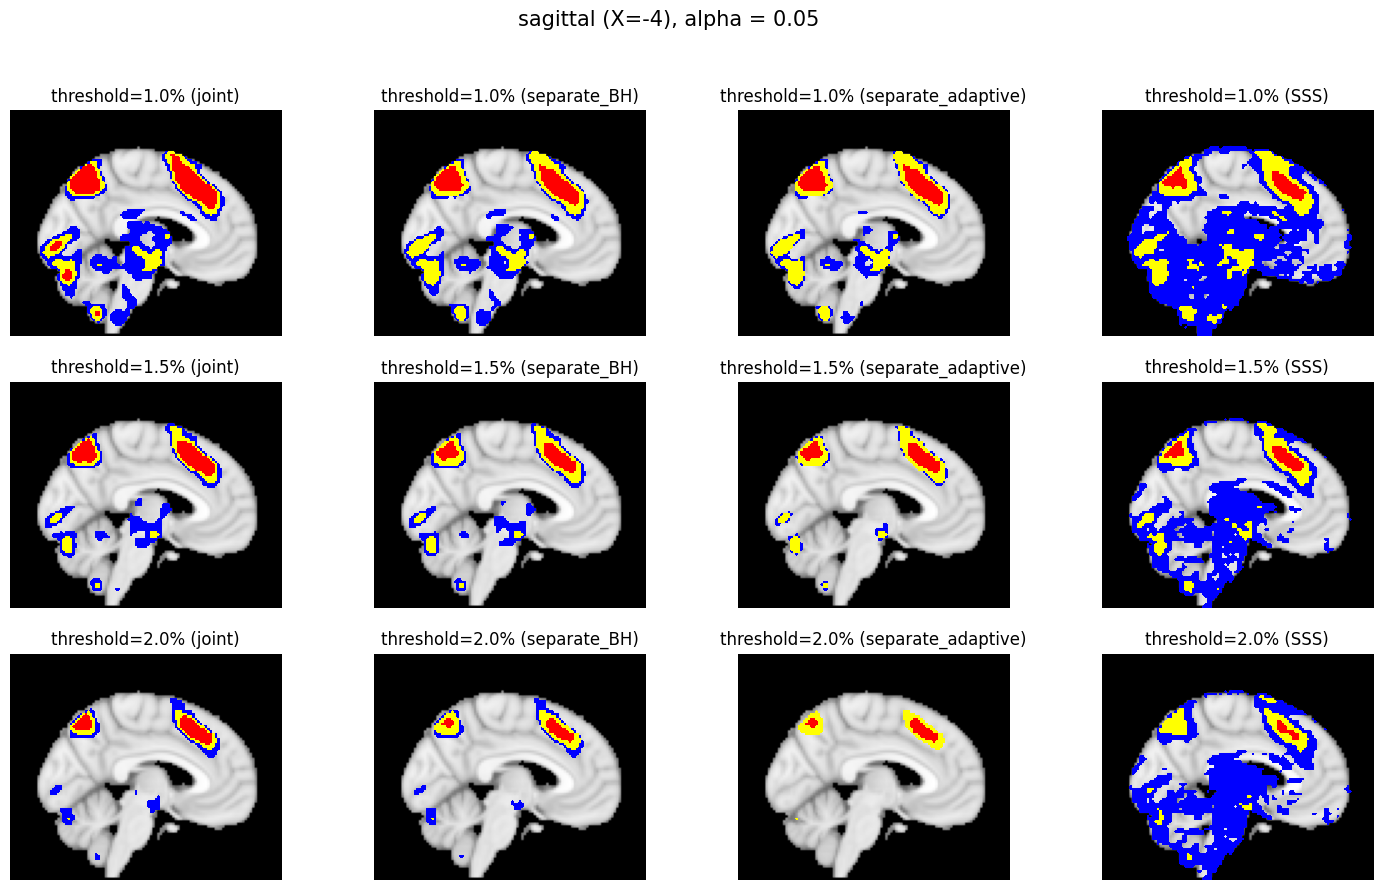

In [107]:
#idx_spm = np.linalg.solve(v_mat, [-4, 16, 48, 1])
thresholds = [10, 15, 20]
background_slc = sagittal_background
misc = "-4"
n_boot = 2
slc_info = [sagittal, "sagittal", sag_x_slice]
plot_confset_HCP(thresholds, background_slc, slc_info, muhat_file, sigma_file, resid_files, misc=misc, alpha=0.05, n_boot=n_boot, figsize=(18,10), fontsize=15)

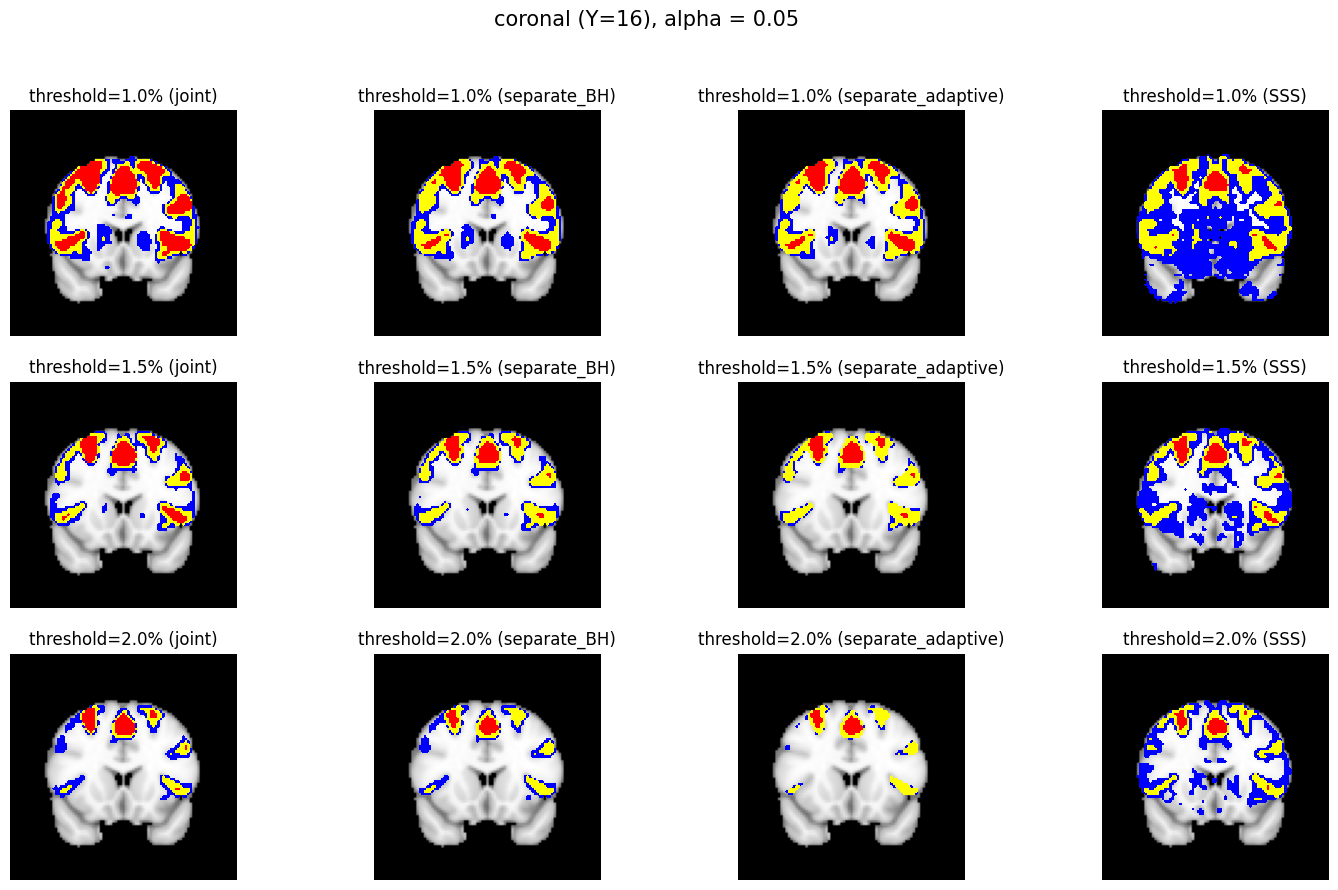

In [108]:
#idx_spm = np.linalg.solve(v_mat, [-4, 16, 48, 1])
thresholds = [10, 15, 20]
misc = "16"
background_slc = coronal_background
slc_info = [coronal, "coronal", cor_y_slice]
plot_confset_HCP(thresholds, background_slc, slc_info, muhat_file, sigma_file, resid_files, misc=misc, alpha=0.05, n_boot=n_boot, figsize=(18,10), fontsize=15)

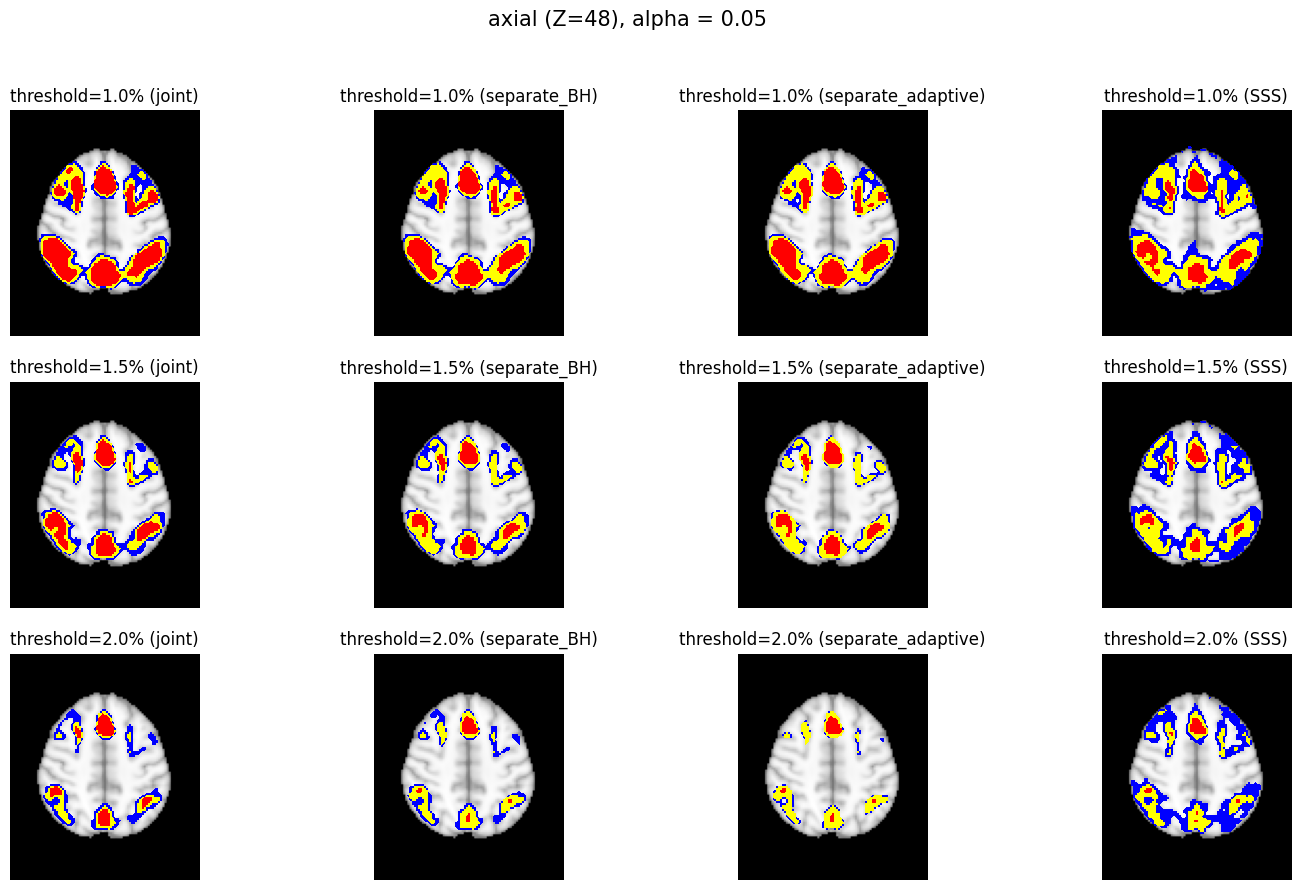

In [109]:
#idx_spm = np.linalg.solve(v_mat, [-4, 16, 48, 1])
thresholds = [10, 15, 20]
misc = "48"
background_slc = axial_background
slc_info = [axial, "axial", axi_z_slice]
plot_confset_HCP(thresholds, background_slc, slc_info, muhat_file, sigma_file, resid_files, misc=misc, alpha=0.05, n_boot=n_boot, figsize=(18,10), fontsize=15)